<a href="https://colab.research.google.com/github/ntxucb/BR41N.IO_SSVEP_Data_Analysis/blob/main/SSVEP_ntxucb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
path = "/content/drive/MyDrive/br41n.io/eeg_data"

In [ ]:
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt
from sklearn.preprocessing import StandardScaler #Scale variables
from sklearn.decomposition import PCA #Decomposition
plt.style.use('seaborn-whitegrid') #Seaborn style

In [ ]:
import sys
if 'google.colab' in sys.modules:
    # Install h2o dependencies
    !pip install requests
    !pip install tabulate
    !pip install "colorama>=0.3.8"
    !pip install future
    # Install h2o
    try:
        import h2o
    except:
        !pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html
     |████████████████████████████████| 175.8 MB 22 kB/s 
  Created wheel for h2o: filename=h2o-3.34.0.3-py2.py3-none-any.whl size=175832480 sha256=650fda854c074e9782b4e9e97545270527aee8d3f3647da9440739cd30ea996d
  Stored in directory: /root/.cache/pip/wheels/2a/52/cf/01f6938288f0731963463ff72510db67f9f3076f801038b2f7
Successfully built h2o


In [ ]:
import h2o
from h2o.automl import H2OAutoML
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.11" 2021-04-20; OpenJDK Runtime Environment (build 11.0.11+9-Ubuntu-0ubuntu2.18.04); OpenJDK 64-Bit Server VM (build 11.0.11+9-Ubuntu-0ubuntu2.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmph40jnzys
  JVM stdout: /tmp/tmph40jnzys/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmph40jnzys/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.3
H2O_cluster_version_age:,10 days
H2O_cluster_name:,H2O_from_python_unknownUser_0i5l01
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.172 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [ ]:
import os
files = os.listdir(path)
files.sort()
print(files)

['subject_1_fvep_led_training_1.mat', 'subject_1_fvep_led_training_2.mat', 'subject_2_fvep_led_training_1.mat', 'subject_2_fvep_led_training_2.mat']


In [ ]:
!pip install mat73

In [ ]:
import mat73
data_dict = mat73.loadmat(f"{path}/{files[0]}")
data_dict.keys()

dict_keys(['y'])

In [ ]:
data_dict["y"].shape

(11, 57728)

In [ ]:
eeg_sub1 = data_dict["y"][1:,:].copy() #remove time
eeg_sub1[0]

array([-1.06033557e+03, -4.39110889e+03, -6.67352490e+03, ...,
       -2.11839333e-01, -1.11481071e+00, -1.45659709e+00])

In [ ]:
# CH10: trigger info (LED on...1, LED off...0);
print(eeg_sub1[8])
(unique, counts) = np.unique(eeg_sub1[8], return_counts=True)
frequencies = np.asarray((unique, counts)).T

print(frequencies)
pd.DataFrame(frequencies)

[0. 0. 0. ... 0. 0. 0.]
[[0.0000e+00 2.0088e+04]
 [1.0000e+00 3.7640e+04]]


,0,1
0,0.0,20088.0
1,1.0,37640.0


In [ ]:
# CH11: LDA classification output
#SSVEP - dectected/not detected?
# What does 0 and 3 mean
print(eeg_sub1[9])
(unique, counts) = np.unique(eeg_sub1[9], return_counts=True)
frequencies = np.asarray((unique, counts)).T

print(frequencies)
pd.DataFrame(frequencies)

[0. 0. 0. ... 0. 0. 0.]
[[0.0000e+00 5.1072e+04]
 [3.0000e+00 6.6560e+03]]


,0,1
0,0.0,51072.0
1,3.0,6656.0


Stimulation frequencies: 15, 12, 10 and 9 Hz (column 1, 2, 3 and 4 in classInfo_4_5.m)<br>
Sampling rate: 256 Hz<br>
CH1: sample time<br>
CH2-9: EEG<br>
CH10: trigger info (LED on...1, LED off...0);<br>
CH11: LDA classification output<br>

In [ ]:
# class info to numpy
class_info = np.array([
[1, 0, 0, 0],
[0, 1, 0, 0],
[0, 0, 1, 0],
[0, 0, 0, 1],
[1, 0, 0, 0],
[0, 1, 0, 0],
[0, 0, 1, 0],
[0, 0, 0, 1],
[1, 0, 0, 0],
[0, 1, 0, 0],
[0, 0, 1, 0],
[0, 0, 0, 1],
[1, 0, 0, 0],
[0, 1, 0, 0],
[0, 0, 1, 0],
[0, 0, 0, 1],
[1, 0, 0, 0],
[0, 1, 0, 0],
[0, 0, 1, 0],
[0, 0, 0, 1]   
])
# print(class_info)
freqs = ["15", "12", "10", "9"] 

labels = pd.DataFrame(class_info, columns = freqs).add_prefix("Freq_")

labels

,Freq_15,Freq_12,Freq_10,Freq_9
0,1,0,0,0
1,0,1,0,0
2,0,0,1,0
3,0,0,0,1
4,1,0,0,0
5,0,1,0,0
6,0,0,1,0
7,0,0,0,1
8,1,0,0,0
9,0,1,0,0


In [ ]:
# We only have to classify if the LED is ON or OFF?

In [ ]:
# Load all files as numpy
eeg_list = []
cols = ["PO7", "PO3","POz", "PO4", "PO8","O1","Oz","O2","Trigger","LDA-Output"]
for file in files:
  print(file)
  data = mat73.loadmat(f"{path}/{file}")
  eeg_dfs = pd.DataFrame(data["y"][1:,:].T, columns = cols)
  eeg_list.append(eeg_dfs)


subject_1_fvep_led_training_1.mat
subject_1_fvep_led_training_2.mat
subject_2_fvep_led_training_1.mat
subject_2_fvep_led_training_2.mat


In [ ]:
#Subject 1 - Training 1
eeg_list[0]

,PO7,PO3,POz,PO4,PO8,O1,Oz,O2,Trigger,LDA-Output
0,-1060.335571,-85.672676,195.264771,353.811188,-518.587891,-298.196686,-304.575867,-697.454468,0.0,0.0
1,-4391.108887,-280.387939,647.012390,1711.082153,-1879.620483,-1563.722046,-1583.941406,-3070.418945,0.0,0.0
2,-6673.524902,-160.418365,389.287079,3495.326660,-1885.986572,-3580.973633,-3586.791748,-5336.872559,0.0,0.0
3,-4101.638184,516.720520,-1195.901123,4289.599121,1123.375977,-5122.143555,-5059.679199,-4925.265625,0.0,0.0
4,-600.986816,1117.116577,-2721.778809,4399.416016,4081.961426,-5982.529297,-5846.979004,-3711.430176,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
57723,6.726040,4.468168,3.468754,3.718039,4.409559,7.837559,7.417085,6.878790,0.0,0.0
57724,3.786460,3.100144,1.307947,3.003564,3.264575,5.195788,6.382321,5.719792,0.0,0.0
57725,-0.211839,-0.429037,-2.325564,-0.241900,0.331145,0.366751,2.436171,2.229627,0.0,0.0
57726,-1.114811,-1.455616,-1.932424,-1.524979,-0.535545,-1.652583,1.070238,1.399415,0.0,0.0


LDA Outputs


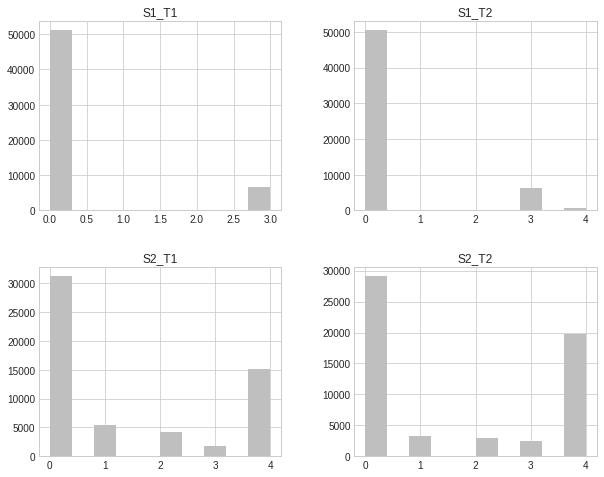

In [ ]:
#LDA Original Classification
ch11 = pd.DataFrame(eeg_list[0].iloc[:,-1])
ch11["S1_T2"] = eeg_list[1].iloc[:,-1]
ch11["S2_T1"] = eeg_list[2].iloc[:,-1]
ch11["S2_T2"] = eeg_list[3].iloc[:,-1]
ch11.rename(columns = {"LDA-Output" : "S1_T1"}, inplace=True)
print("LDA Outputs")
ch11.hist(color="0.75", figsize=(10,8));


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
eeg_list[0].iloc[:,10].isna().sum()

0

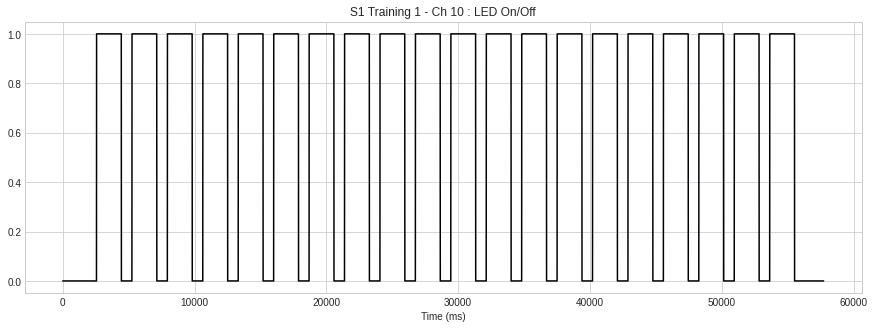

In [ ]:
### Trigger vs. Time (Plot of events)
plt.figure(figsize=(15,5))
eeg_list[0].iloc[:,9].plot(colormap='inferno');
plt.title("S1 Training 1 - Ch 10 : LED On/Off");
plt.xlabel("Time (ms)");

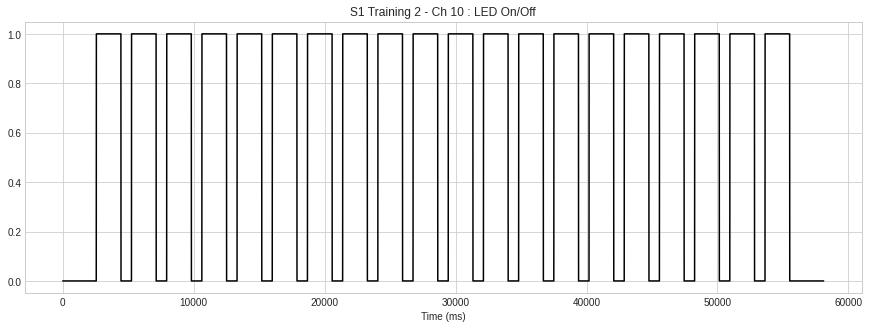

In [ ]:
plt.figure(figsize=(15,5))
eeg_list[1].iloc[:,9].plot(colormap='inferno');
plt.title("S1 Training 2 - Ch 10 : LED On/Off");
plt.xlabel("Time (ms)");

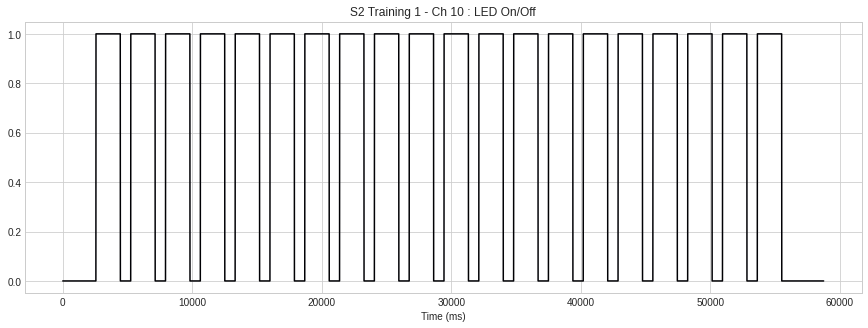

In [ ]:
plt.figure(figsize=(15,5))
eeg_list[2].iloc[:,9].plot(colormap='inferno');
plt.title("S2 Training 1 - Ch 10 : LED On/Off");
plt.xlabel("Time (ms)");

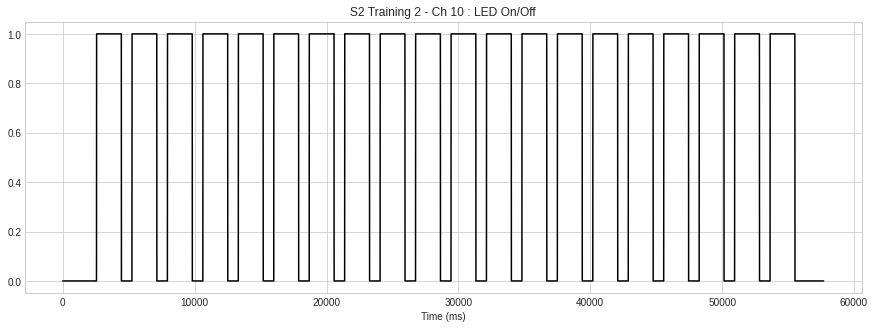

In [ ]:
plt.figure(figsize=(15,5))
eeg_list[3].iloc[:,9].plot(colormap='inferno');
plt.title("S2 Training 2 - Ch 10 : LED On/Off");
plt.xlabel("Time (ms)");

In [ ]:
#There are 20 events in the signal each event maps to a row of the classes

In [ ]:
labels = ["Freq_15",	"Freq_12",	"Freq_10",	"Freq_9"]*5
labels

['Freq_15',
 'Freq_12',
 'Freq_10',
 'Freq_9',
 'Freq_15',
 'Freq_12',
 'Freq_10',
 'Freq_9',
 'Freq_15',
 'Freq_12',
 'Freq_10',
 'Freq_9',
 'Freq_15',
 'Freq_12',
 'Freq_10',
 'Freq_9',
 'Freq_15',
 'Freq_12',
 'Freq_10',
 'Freq_9']

5200


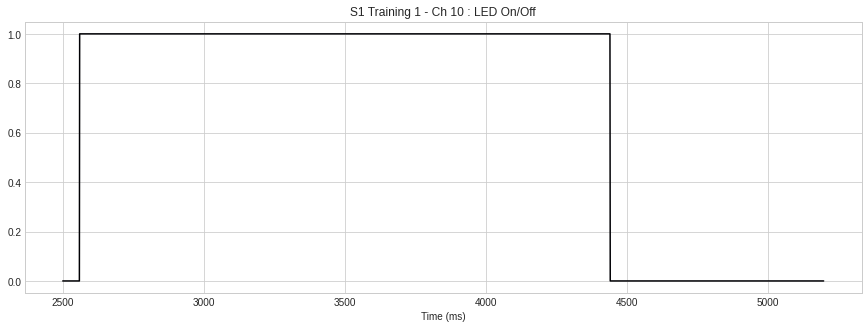

In [ ]:
start = 2500
step = 2700
segment = 3

end = (start + step)
print(end)
plt.figure(figsize=(15,5))
eeg_list[1].iloc[start:end,8].plot(colormap='inferno');
plt.title("S1 Training 1 - Ch 10 : LED On/Off");
plt.xlabel("Time (ms)");

In [ ]:
def correct_labels(num):
  correct_labels = []
  id = 0
  ant = -1.0
  data = eeg_list[num].iloc[:,8]
  for dp in data:
    if dp == 0.0:
      correct_labels.append('No_Target')
    if ant == -1.0:
      ant = dp
    else:
      if ant==1.0 and dp == 0.0:
        id+=1
    if dp == 1.0:
      correct_labels.append(labels[id])
    ant = dp
  eeg_list[num]['Label'] = correct_labels

In [ ]:
labels_num = [15, 12, 10, 9]*5
labels_num

[15, 12, 10, 9, 15, 12, 10, 9, 15, 12, 10, 9, 15, 12, 10, 9, 15, 12, 10, 9]

In [ ]:
def correct_events(num):
  correct_labels = []
  id = 0
  ant = -1.0
  data = eeg_list[num].iloc[:,8]
  for dp in data:
    if dp == 0.0:
      correct_labels.append(0)
    if ant == -1.0:
      ant = dp
    else:
      if ant==1.0 and dp == 0.0:
        id+=1
    if dp == 1.0:
      correct_labels.append(labels_num[id])
    ant = dp
  eeg_list[num]['Event'] = correct_labels

In [ ]:
# Run to fix labels
for i in range(len(eeg_list)):
  # correct_labels(i)
  correct_events(i)

In [ ]:
eeg_list[3]

,PO7,PO3,POz,PO4,PO8,O1,Oz,O2,Trigger,LDA-Output,Event
0,-85.981537,-553.993164,303.872742,-56.809189,-487.070251,-165.701904,135.098892,-801.984131,0.0,0.0,0
1,-457.985626,-1912.881470,1232.419434,-201.222427,-2161.820068,-471.416473,1116.425293,-3226.739990,0.0,0.0,0
2,-1061.565430,-1519.074951,1774.364624,-182.311615,-3817.674561,53.352119,3720.987061,-4566.417480,0.0,0.0,0
3,-1497.568481,2366.425781,844.814453,181.358978,-3651.555908,1819.778198,7095.944824,-2040.714355,0.0,0.0,0
4,-1638.541748,6094.715820,-321.388855,539.664429,-2906.458496,3295.383301,9416.365234,950.510559,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...
57692,-7.339821,1.222771,3.389736,10.630192,5.421735,-12.867040,9.760956,4.420230,0.0,0.0,0
57693,-1.628320,6.624181,5.168508,6.914836,2.934678,-0.394954,15.169564,1.625323,0.0,0.0,0
57694,-6.124949,4.528360,1.870061,0.257741,-2.222052,-2.890369,11.295901,-5.169265,0.0,0.0,0
57695,-18.818218,-6.786640,-7.873328,-5.966027,-7.592616,-23.567797,-5.511063,-13.207706,0.0,0.0,0


In [ ]:
# subj = [1,1,2,2]
# t_sess = [1,2,1,2]
# csv_path = "/content/drive/MyDrive/br41n.io/eeg_csv"
# for s, file, se in zip(subj, eeg_list,t_sess):
#   file.to_csv(f"{csv_path}/S{s}_T{se}.csv")

In [ ]:
# remap list 
# eeg_list[0].iloc[:,9]
labels_list = []
start = 2500
step = 2700
signal_length = start + step
# end = (start + step)
no_target = "No_Target"

tot_segments = int(eeg_list[0].shape[0] / step) #Num of segments of the signal

# up to point 2500 : No Target
for i in range(start): 

  labels_list.append(no_target)

for seg_idx in range(tot_segments-1):
  # seg_idx : current segment of the whole signal to be analyzed
  segment = eeg_list[0].iloc[start:signal_length,8]
  # print(seg_idx)
  # print(segment)
  # plt.plot(segment)
  for val in segment:
    # print(val)
    # lbl_idx = 0
    if val == 0:
      labels_list.append(no_target)
      # lbl_idx += 1
    else:
      labels_list.append(labels[seg_idx])
  start += step
  signal_length += step

diff = eeg_list[0].shape[0] - len(labels_list) 
print(diff)

for i in range(diff):
  labels_list.append(no_target)



    # next segment


1228


In [ ]:
print(len(labels_list))
eeg_list[0].shape

57728


(57728, 10)

In [ ]:
pd.DataFrame(labels_list).value_counts()

No_Target    20088
Freq_12       9458
Freq_10       9458
Freq_15       9446
Freq_9        9278
dtype: int64

In [ ]:
eeg_list[0]["Label"] = labels_list
eeg_list[0]

,PO7,PO3,POz,PO4,PO8,O1,Oz,O2,Trigger,LDA-Output,Label
0,-1060.335571,-85.672676,195.264771,353.811188,-518.587891,-298.196686,-304.575867,-697.454468,0.0,0.0,No_Target
1,-4391.108887,-280.387939,647.012390,1711.082153,-1879.620483,-1563.722046,-1583.941406,-3070.418945,0.0,0.0,No_Target
2,-6673.524902,-160.418365,389.287079,3495.326660,-1885.986572,-3580.973633,-3586.791748,-5336.872559,0.0,0.0,No_Target
3,-4101.638184,516.720520,-1195.901123,4289.599121,1123.375977,-5122.143555,-5059.679199,-4925.265625,0.0,0.0,No_Target
4,-600.986816,1117.116577,-2721.778809,4399.416016,4081.961426,-5982.529297,-5846.979004,-3711.430176,0.0,0.0,No_Target
...,...,...,...,...,...,...,...,...,...,...,...
57723,6.726040,4.468168,3.468754,3.718039,4.409559,7.837559,7.417085,6.878790,0.0,0.0,No_Target
57724,3.786460,3.100144,1.307947,3.003564,3.264575,5.195788,6.382321,5.719792,0.0,0.0,No_Target
57725,-0.211839,-0.429037,-2.325564,-0.241900,0.331145,0.366751,2.436171,2.229627,0.0,0.0,No_Target
57726,-1.114811,-1.455616,-1.932424,-1.524979,-0.535545,-1.652583,1.070238,1.399415,0.0,0.0,No_Target


In [ ]:
csv_path = "/content/drive/MyDrive/br41n.io/eeg_csv"
eeg_list[0].to_csv(f"{csv_path}/S1_T1_prepared.csv")

In [ ]:
#Which pipeline is more efficient?
#Ch with more prediction power
#One-shot training
#PCA
#Wavelet
#Wavelet - PCA


In [ ]:
h2o_session_data = h2o.H2OFrame(python_obj=eeg_list[0])
train, test = h2o_session_data.split_frame(ratios=[0.8], seed=420)
y = "Label"
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

max_models=10
x = train.columns[:-3] #only names of columns
aml = H2OAutoML(max_models=max_models, seed=420)
aml.train(x=x, y=y, training_frame=train)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_2_AutoML_1_20211017_190123


Model Summary: 


,,number_of_trees
0,,88.0




ModelMetricsMultinomial: xgboost
** Reported on train data. **

MSE: 0.38976806480814463
RMSE: 0.6243140754525278
LogLoss: 1.005486936491652
Mean Per-Class Error: 0.33473647908914184
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,Freq_10,Freq_12,Freq_15,Freq_9,No_Target,Error,Rate
0,4684.0,337.0,300.0,255.0,1975.0,0.379685,"2,867 / 7,551"
1,377.0,4631.0,316.0,248.0,2022.0,0.390176,"2,963 / 7,594"
2,377.0,368.0,4334.0,316.0,2186.0,0.428308,"3,247 / 7,581"
3,361.0,330.0,322.0,4443.0,1984.0,0.402823,"2,997 / 7,440"
4,357.0,306.0,268.0,233.0,14849.0,0.072691,"1,164 / 16,013"
5,6156.0,5972.0,5540.0,5495.0,23016.0,0.286667,"13,238 / 46,179"



Top-5 Hit Ratios: 


,k,hit_ratio
0,1,0.713333
1,2,0.883757
2,3,0.955564
3,4,0.987852
4,5,1.000000



ModelMetricsMultinomial: xgboost
** Reported on cross-validation data. **

MSE: 0.5682412833765279
RMSE: 0.7538178051601911
LogLoss: 1.5219789642573862
Mean Per-Class Error: 0.744150990681731
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,Freq_10,Freq_12,Freq_15,Freq_9,No_Target,Error,Rate
0,1285.0,765.0,861.0,701.0,3939.0,0.829824,"6,266 / 7,551"
1,859.0,1168.0,865.0,700.0,4002.0,0.846194,"6,426 / 7,594"
2,897.0,811.0,1123.0,682.0,4068.0,0.851867,"6,458 / 7,581"
3,857.0,785.0,803.0,1015.0,3980.0,0.863575,"6,425 / 7,440"
4,1418.0,1268.0,1373.0,1214.0,10740.0,0.329295,"5,273 / 16,013"
5,5316.0,4797.0,5025.0,4312.0,26729.0,0.668009,"30,848 / 46,179"



Top-5 Hit Ratios: 


,k,hit_ratio
0,1,0.331991
1,2,0.543949
2,3,0.718725
3,4,0.868750
4,5,1.000000



Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.331991,0.002922,0.327090,0.333911,0.332612,0.334452,0.331890
1,auc,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
2,err,0.668009,0.002922,0.672910,0.666089,0.667389,0.665548,0.668110
3,err_count,6169.600000,26.987034,6215.000000,6152.000000,6164.000000,6147.000000,6170.000000
4,logloss,1.521979,0.008422,1.521854,1.524686,1.519740,1.510161,1.533454
5,max_per_class_error,0.864233,0.010595,0.868191,0.854029,0.879195,0.865682,0.854069
6,mean_per_class_accuracy,0.255852,0.004362,0.250128,0.258744,0.254496,0.254458,0.261436
7,mean_per_class_error,0.744148,0.004362,0.749872,0.741256,0.745504,0.745542,0.738564
8,mse,0.568241,0.001478,0.570331,0.567625,0.569193,0.566756,0.567301
9,pr_auc,NaN,0.000000,NaN,NaN,NaN,NaN,NaN



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_classification_error,training_auc,training_pr_auc
0,,2021-10-17 19:12:50,5 min 45.096 sec,0.0,0.800000,1.609438,0.653241,NaN,NaN
1,,2021-10-17 19:12:52,5 min 46.572 sec,5.0,0.763809,1.476904,0.640248,NaN,NaN
2,,2021-10-17 19:12:53,5 min 47.883 sec,10.0,0.752615,1.439116,0.635938,NaN,NaN
3,,2021-10-17 19:12:55,5 min 49.344 sec,15.0,0.743429,1.403769,0.619156,NaN,NaN
4,,2021-10-17 19:12:56,5 min 50.913 sec,20.0,0.734585,1.370752,0.596981,NaN,NaN
5,,2021-10-17 19:12:58,5 min 52.610 sec,25.0,0.724743,1.334006,0.563156,NaN,NaN
6,,2021-10-17 19:13:00,5 min 55.113 sec,30.0,0.716290,1.303308,0.533684,NaN,NaN
7,,2021-10-17 19:13:02,5 min 57.144 sec,35.0,0.707530,1.271693,0.503562,NaN,NaN
8,,2021-10-17 19:13:05,5 min 59.364 sec,40.0,0.698012,1.238808,0.474718,NaN,NaN
9,,2021-10-17 19:13:07,6 min 1.784 sec,45.0,0.690254,1.212225,0.451807,NaN,NaN



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,PO4,12518.921875,1.000000,0.134364
1,Oz,12464.629883,0.995663,0.133781
2,PO8,12125.660156,0.968587,0.130143
3,PO7,11705.953125,0.935061,0.125639
4,PO3,11232.482422,0.897240,0.120557
5,O2,11202.799805,0.894869,0.120238
6,O1,11048.472656,0.882542,0.118582
7,POz,10872.780273,0.868508,0.116696


# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,mean_per_class_error,logloss,rmse,mse,training_time_ms,predict_time_per_row_ms,algo
XGBoost_2_AutoML_1_20211017_190123,0.744151,1.52198,0.753818,0.568241,49871,0.080304,XGBoost
XGBoost_1_AutoML_1_20211017_190123,0.750766,1.5023,0.755768,0.571185,16404,0.028079,XGBoost
StackedEnsemble_BestOfFamily_4_AutoML_1_20211017_190123,0.753219,1.48625,0.753749,0.568138,260966,0.206246,StackedEnsemble
StackedEnsemble_AllModels_3_AutoML_1_20211017_190123,0.753858,1.4887,0.753554,0.567844,473651,0.378425,StackedEnsemble
StackedEnsemble_AllModels_2_AutoML_1_20211017_190123,0.755817,1.46399,0.752646,0.566477,106780,0.369857,StackedEnsemble
StackedEnsemble_AllModels_4_AutoML_1_20211017_190123,0.757149,1.47106,0.753152,0.567238,294105,0.383247,StackedEnsemble
StackedEnsemble_AllModels_1_AutoML_1_20211017_190123,0.758302,1.46565,0.753283,0.567435,92472,0.302232,StackedEnsemble
StackedEnsemble_BestOfFamily_5_AutoML_1_20211017_190123,0.758452,1.47208,0.753517,0.567788,164628,0.240135,StackedEnsemble
StackedEnsemble_BestOfFamily_3_AutoML_1_20211017_190123,0.759088,1.46637,0.753447,0.567682,58827,0.202848,StackedEnsemble
StackedEnsemble_BestOfFamily_2_AutoML_1_20211017_190123,0.760026,1.46848,0.754155,0.56875,50289,0.169679,StackedEnsemble


# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## XGBoost_2_AutoML_1_20211017_190123


Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,Freq_10,Freq_12,Freq_15,Freq_9,No_Target,Error,Rate
0,307.0,222.0,167.0,170.0,1041.0,0.839014,"1,600 / 1,907"
1,197.0,258.0,182.0,194.0,1033.0,0.861588,"1,606 / 1,864"
2,200.0,199.0,260.0,195.0,1011.0,0.860590,"1,605 / 1,865"
3,210.0,182.0,183.0,254.0,1009.0,0.861806,"1,584 / 1,838"
4,351.0,348.0,329.0,298.0,2749.0,0.325399,"1,326 / 4,075"
5,1265.0,1209.0,1121.0,1111.0,6843.0,0.668543,"7,721 / 11,549"


# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

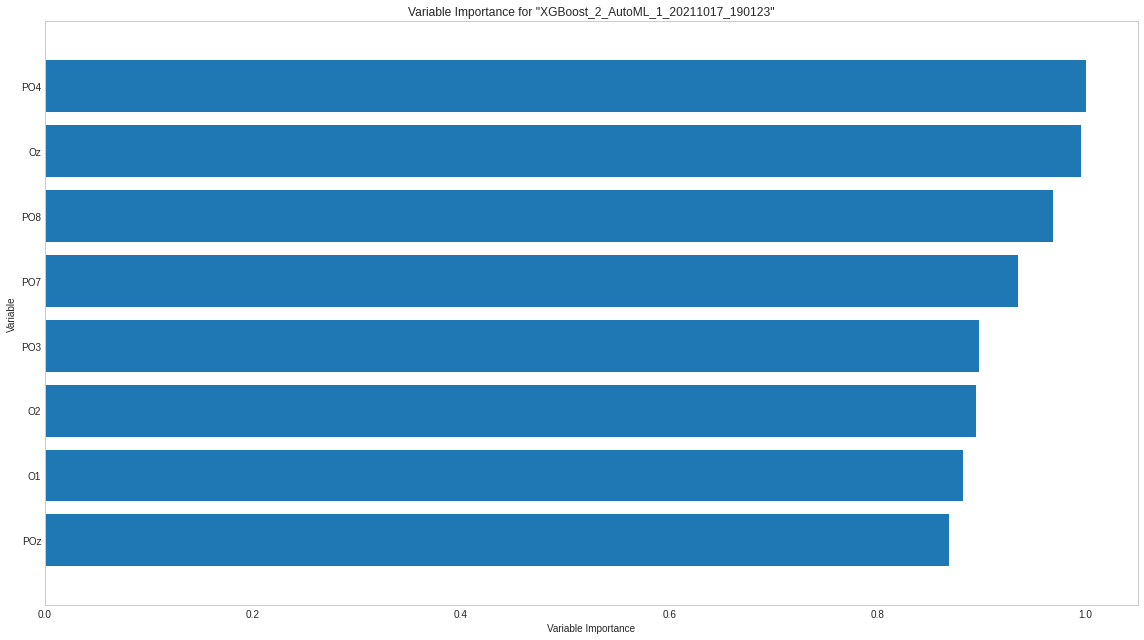

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

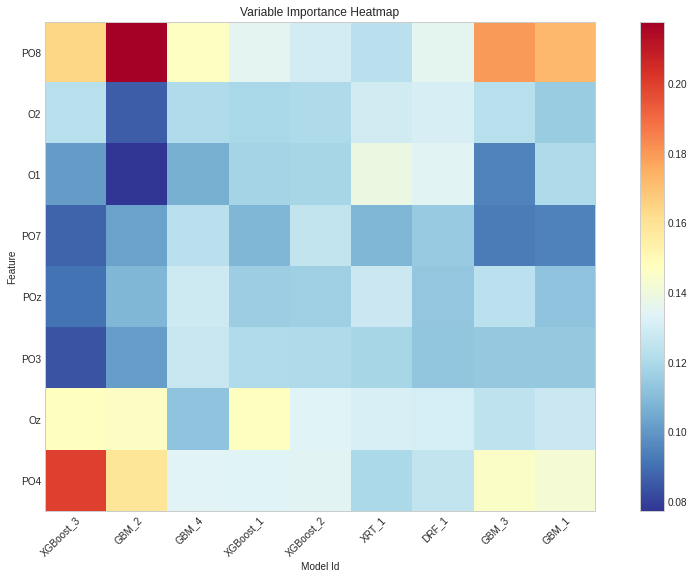

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

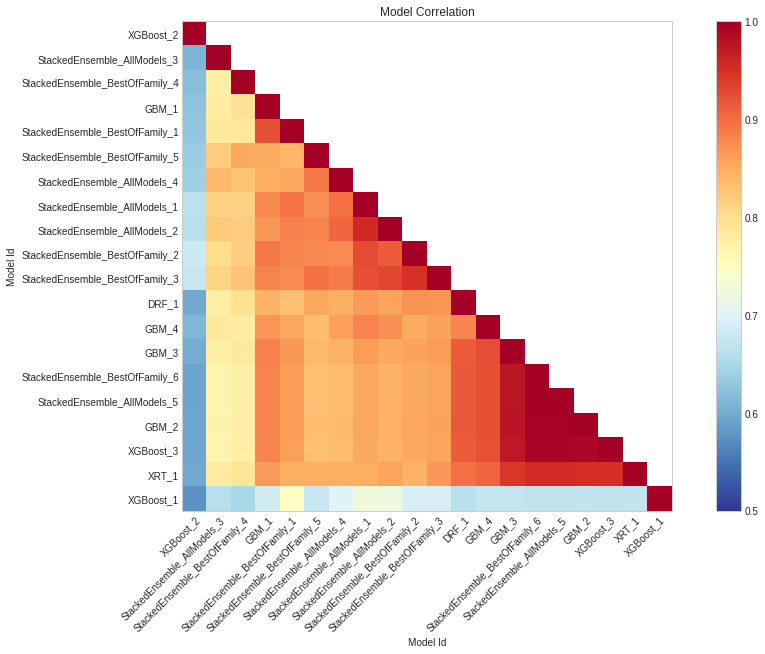

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

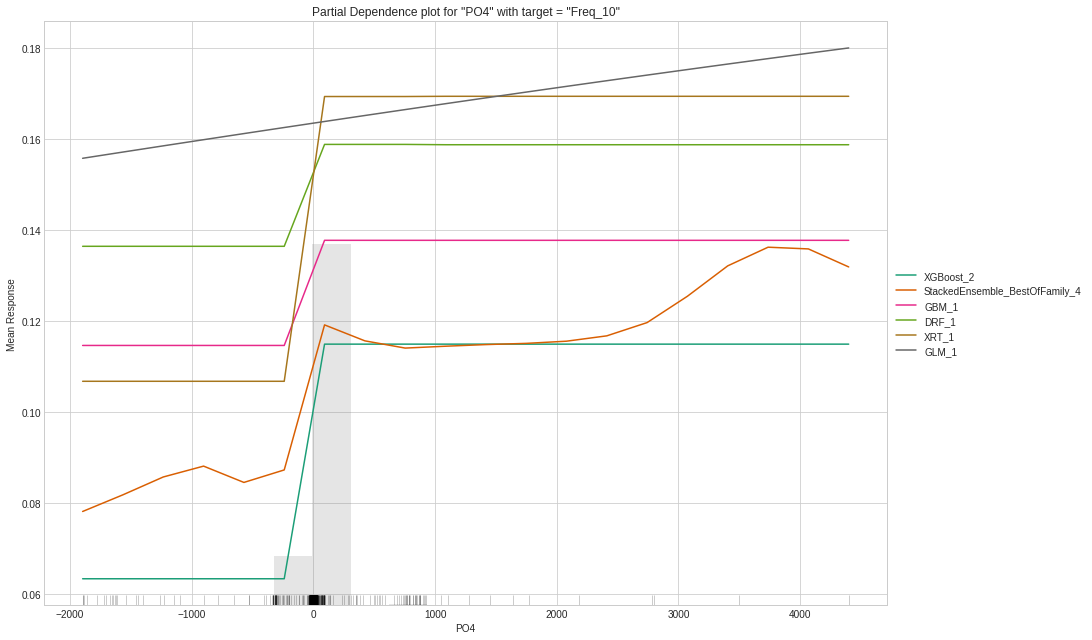

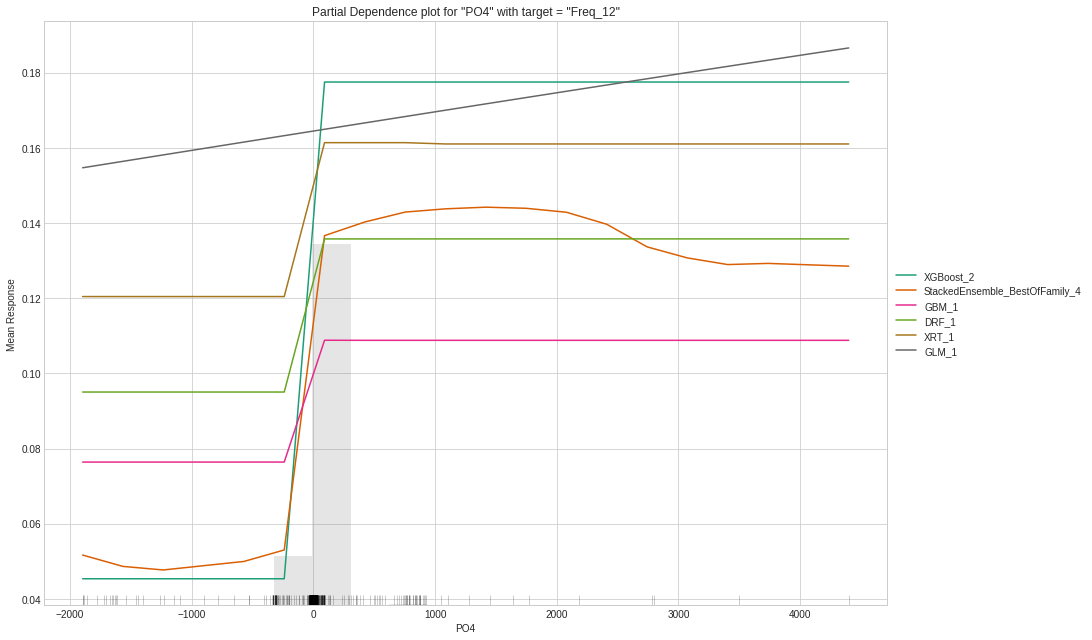

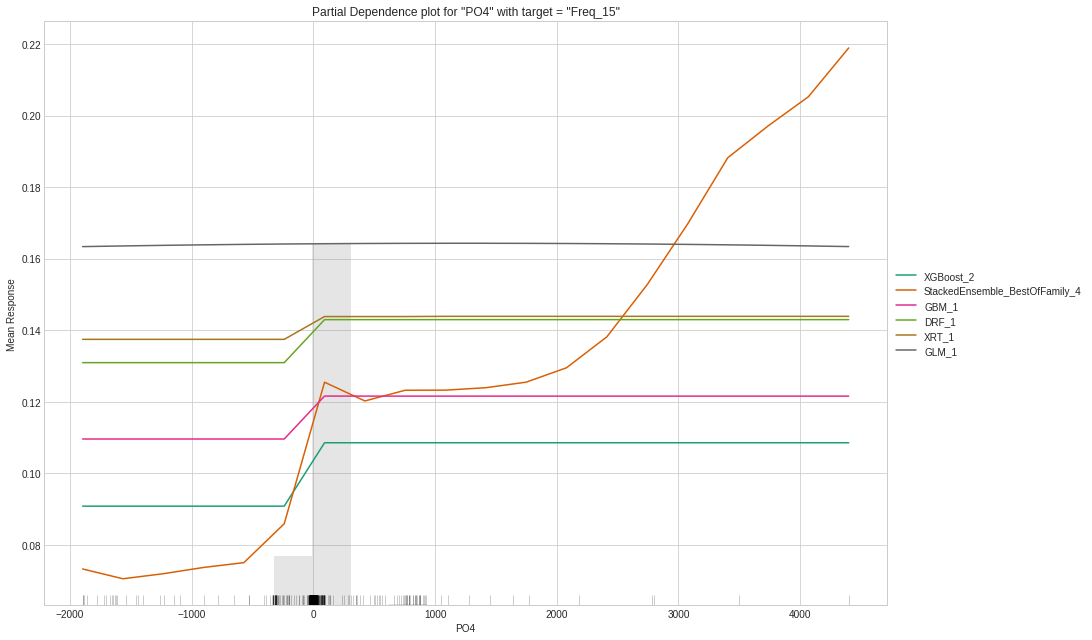

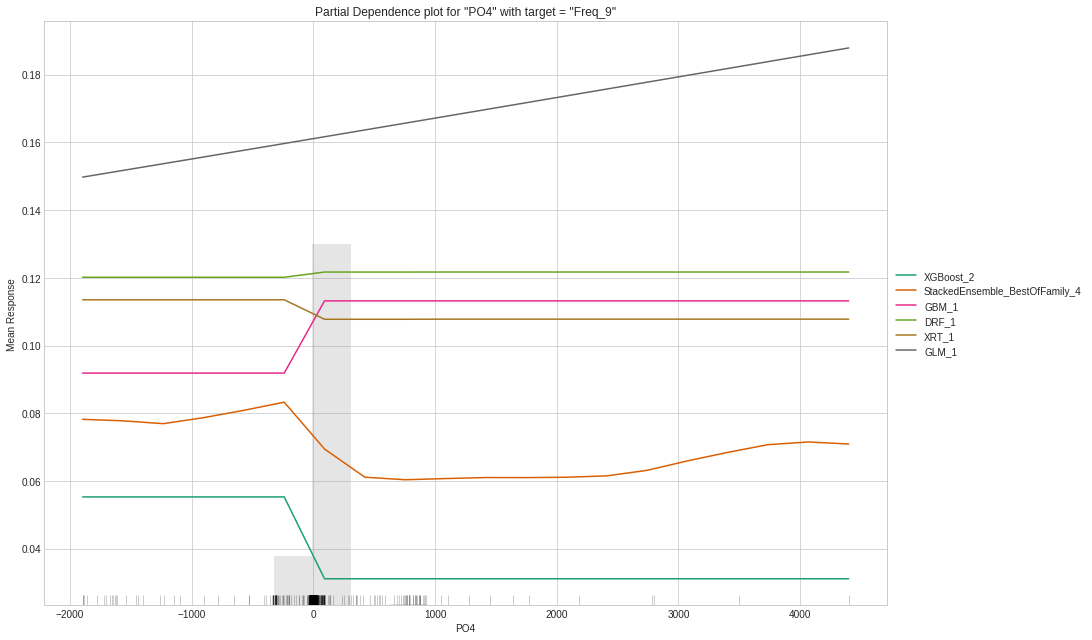

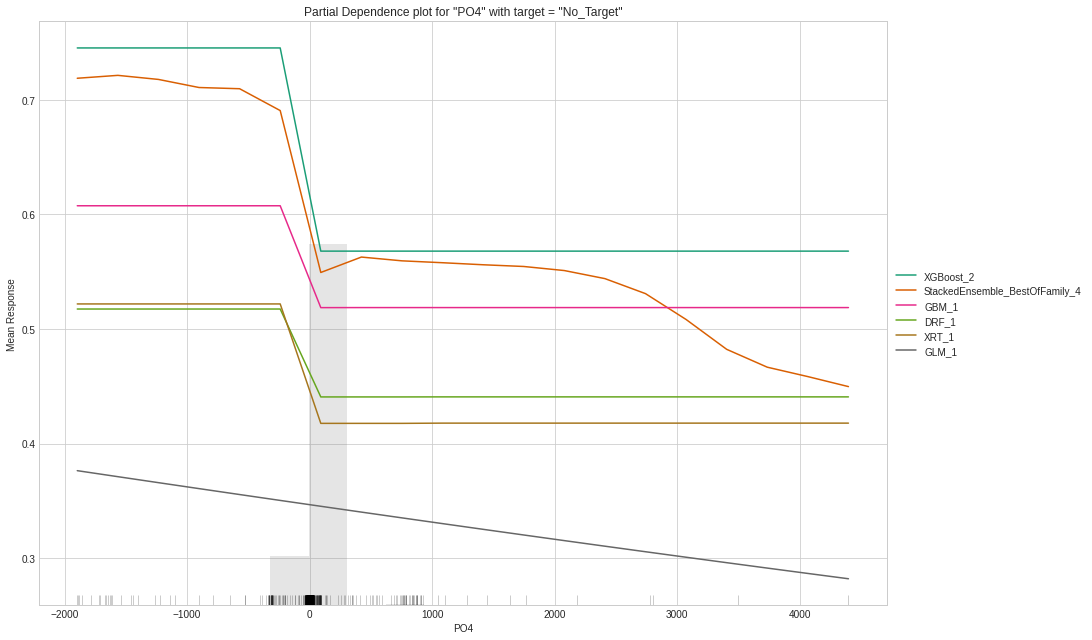

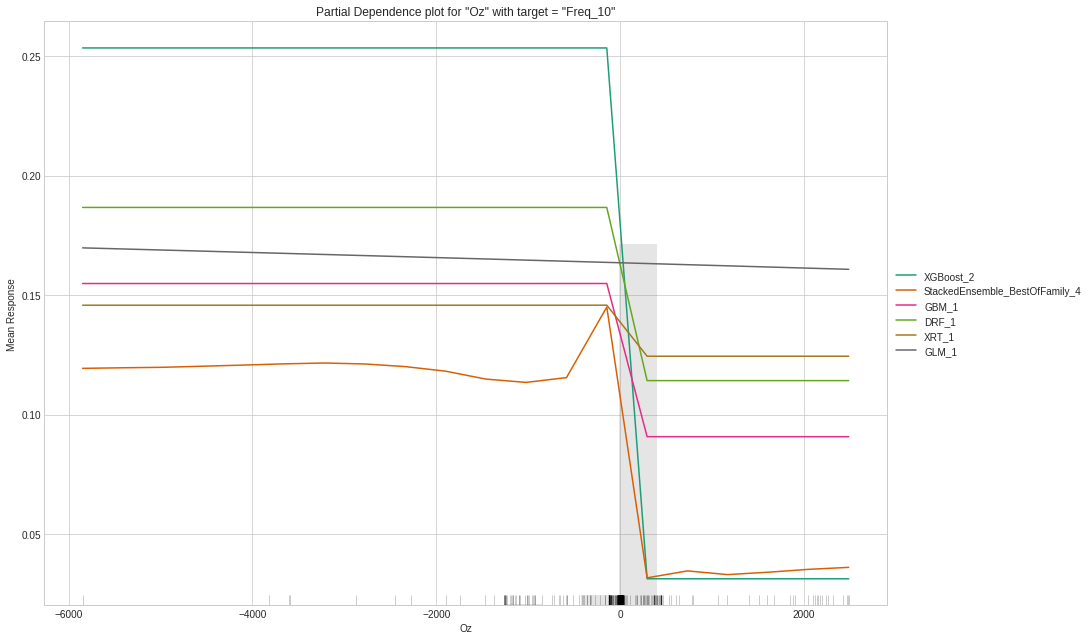

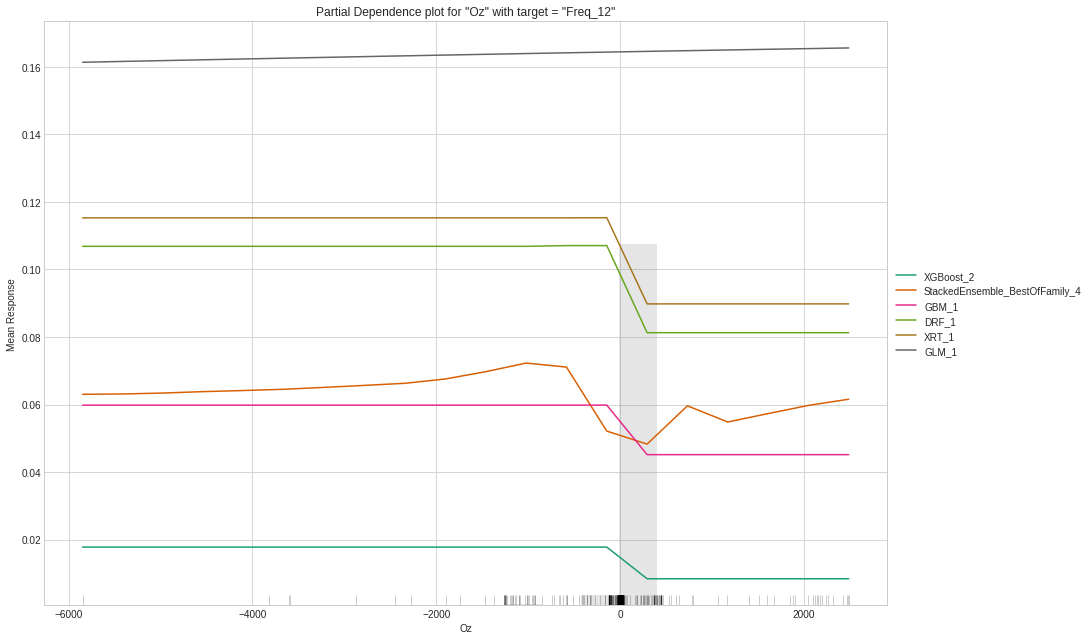

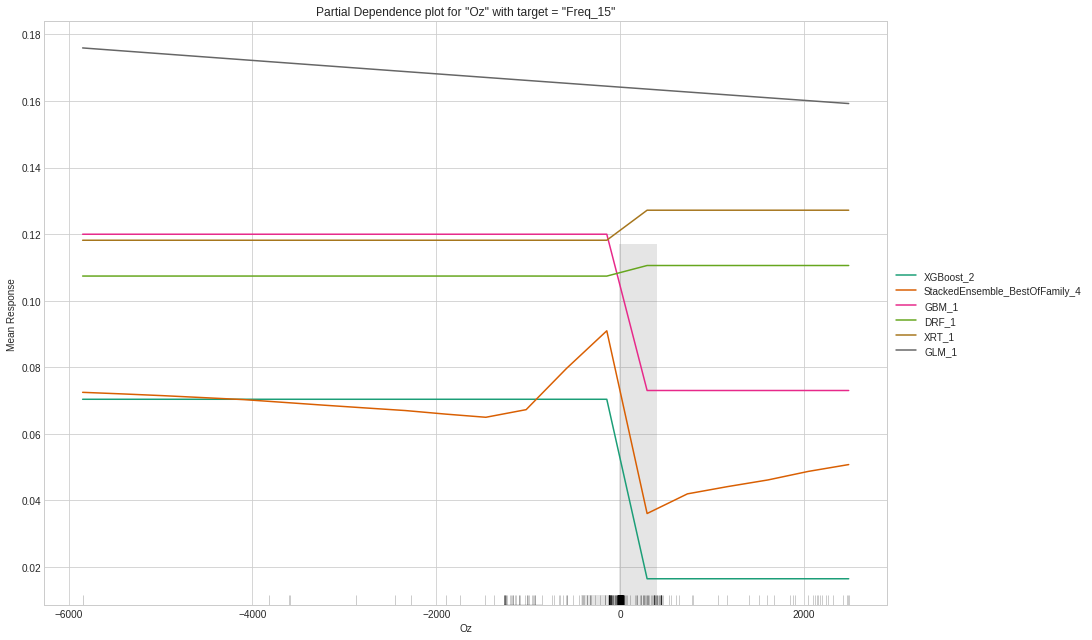

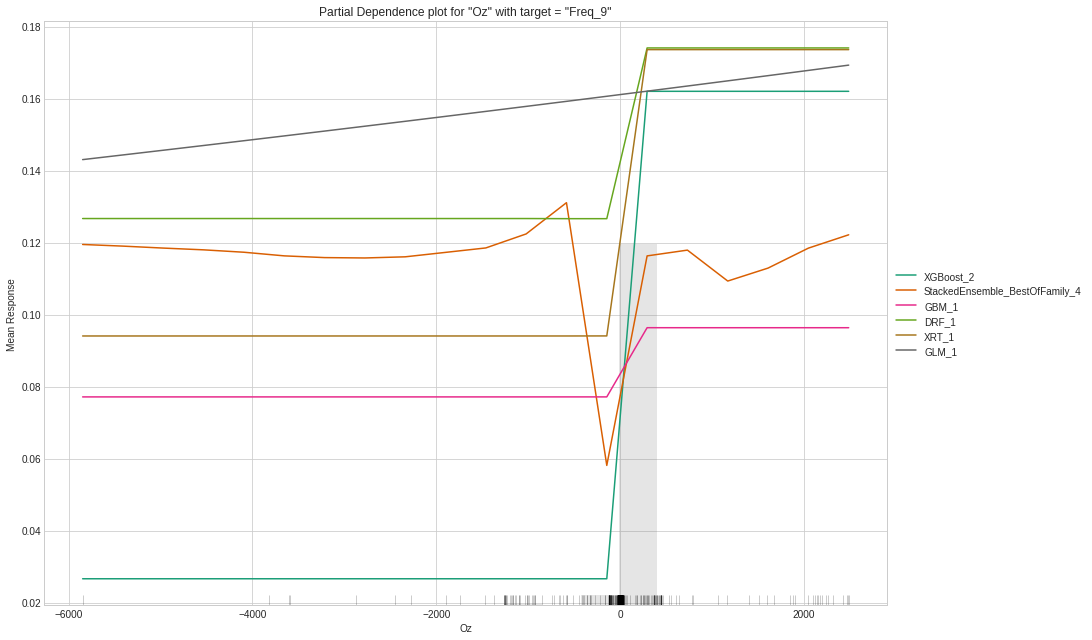

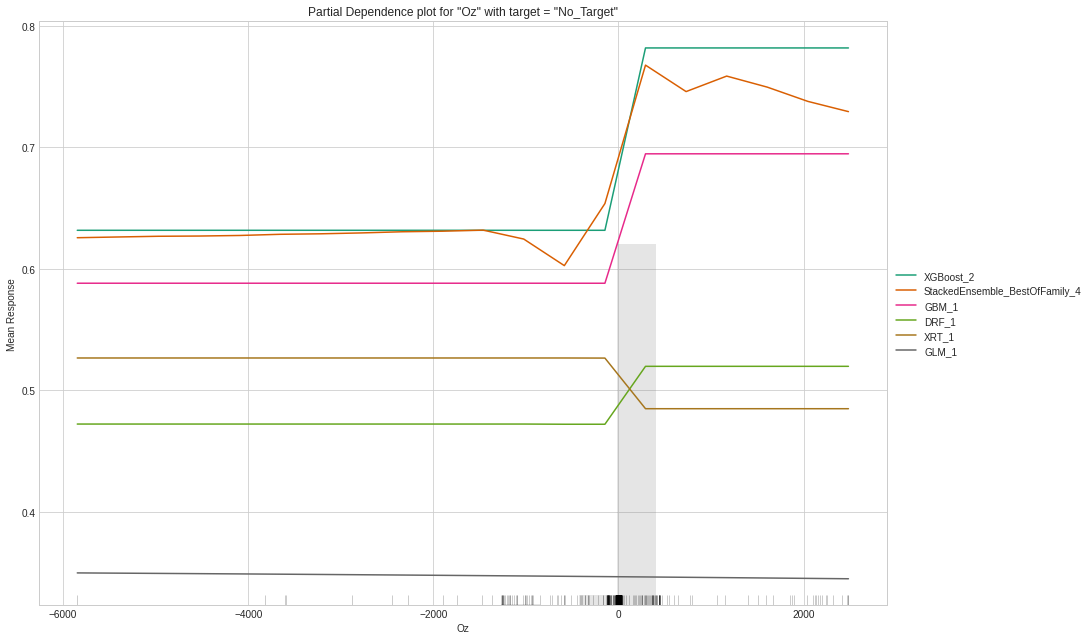

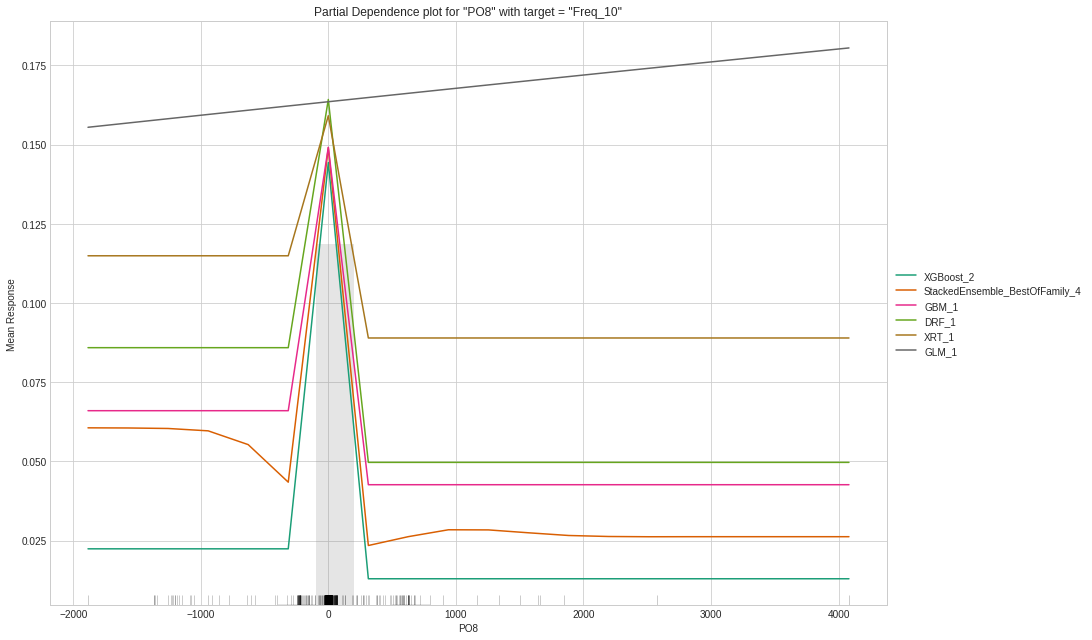

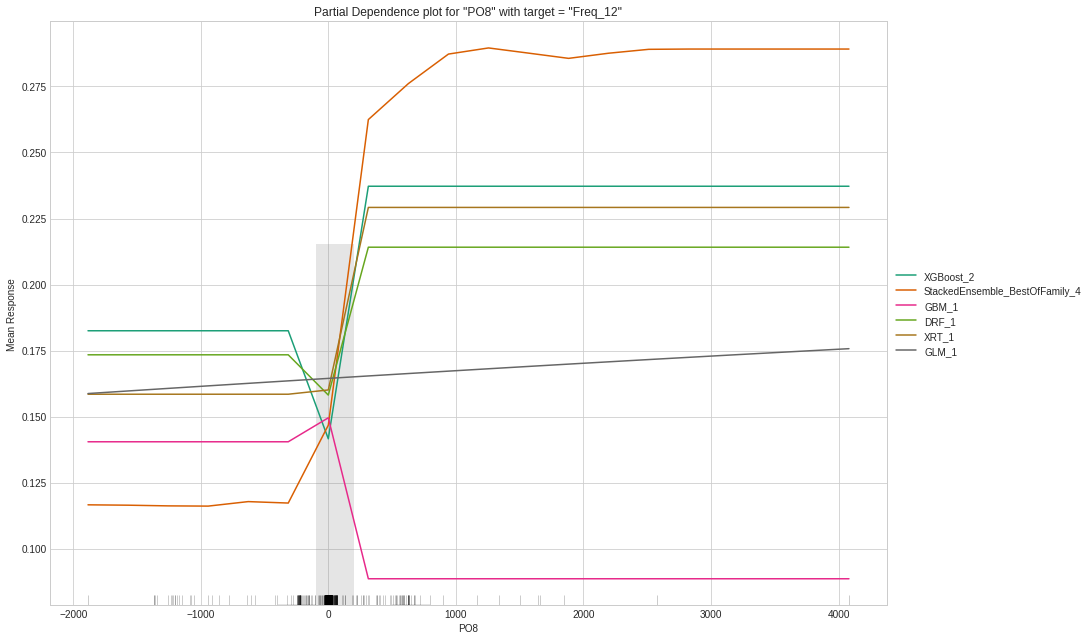

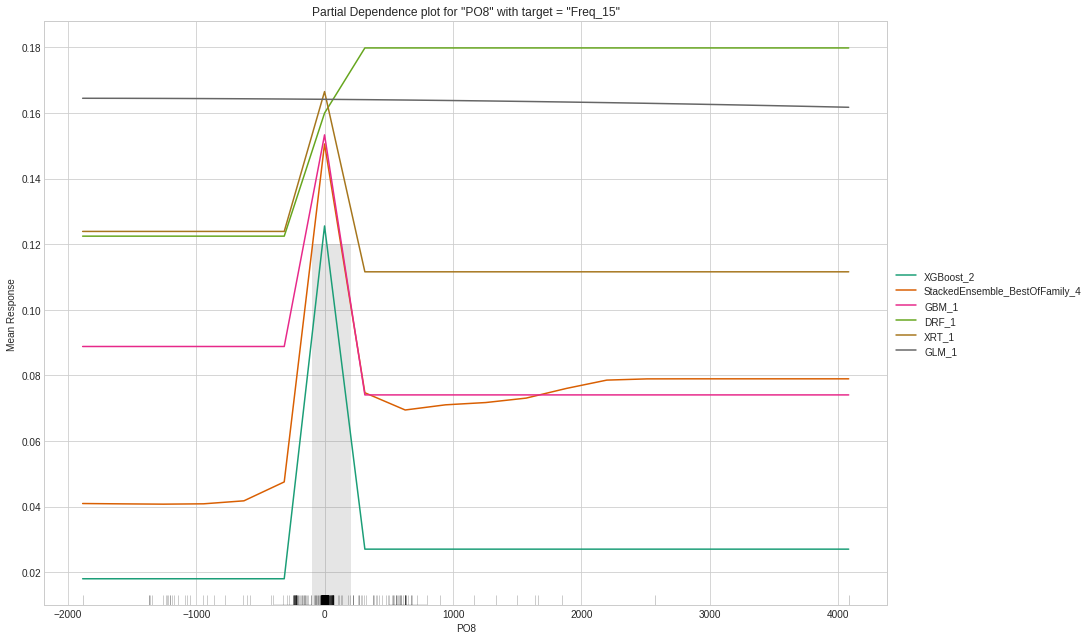

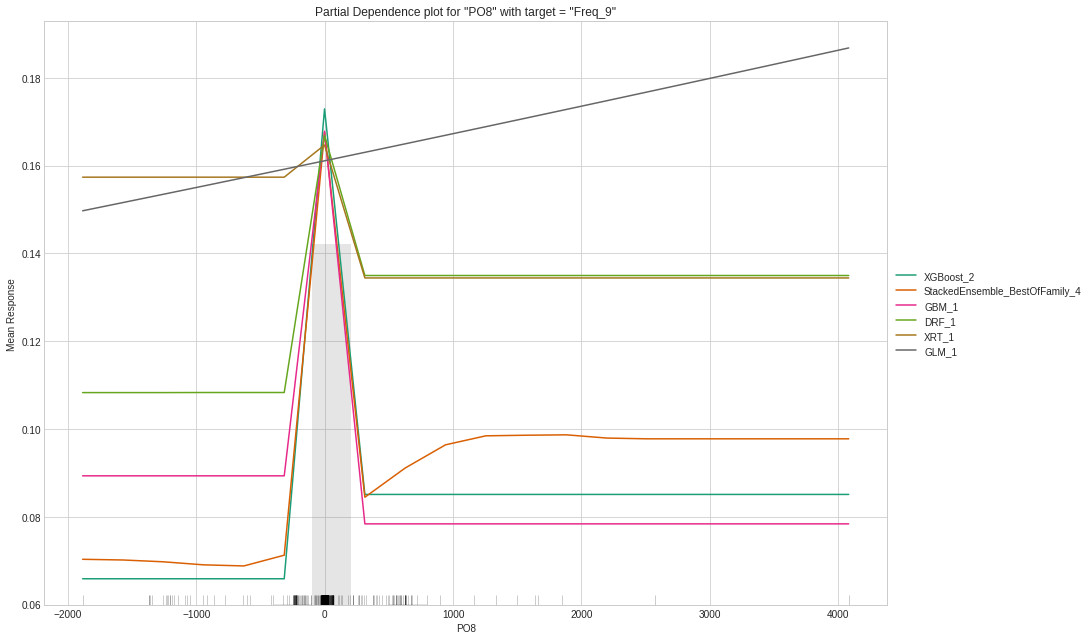

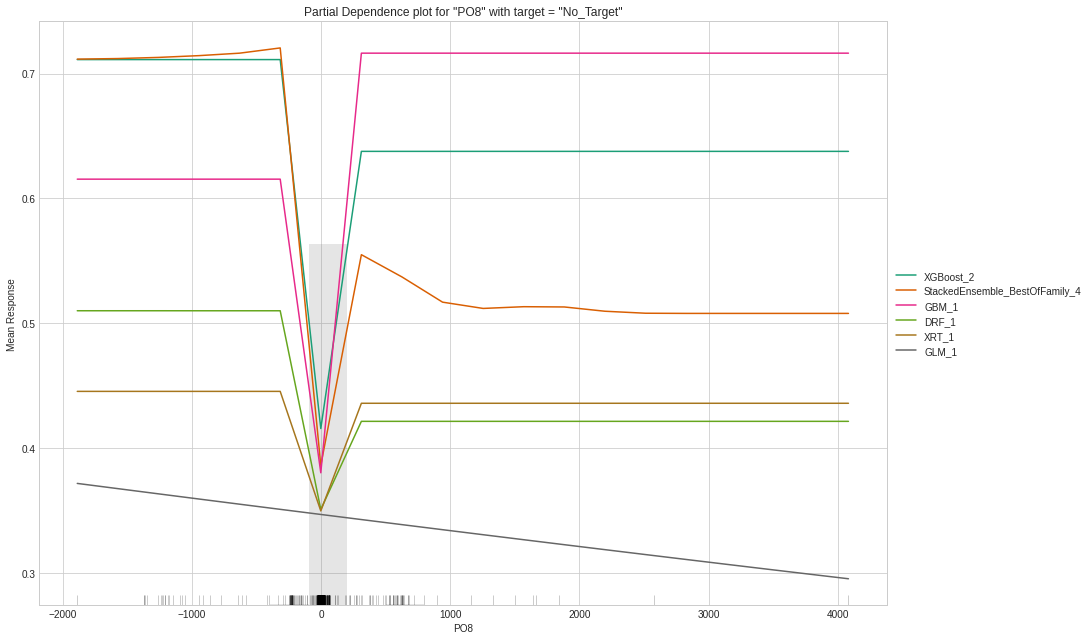

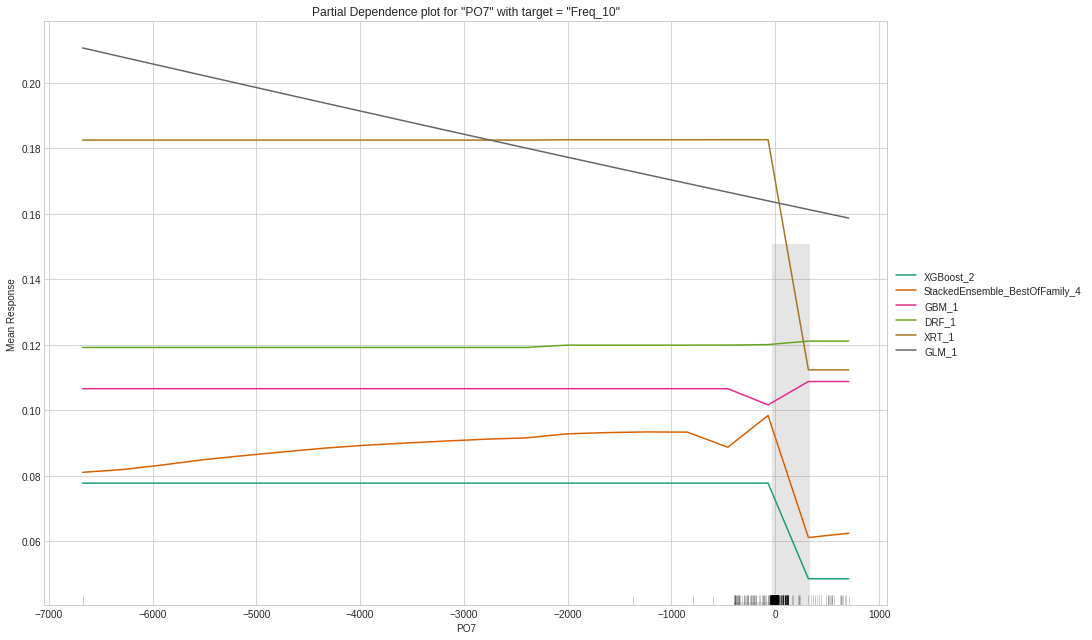

H2OJobCancelled: ignored

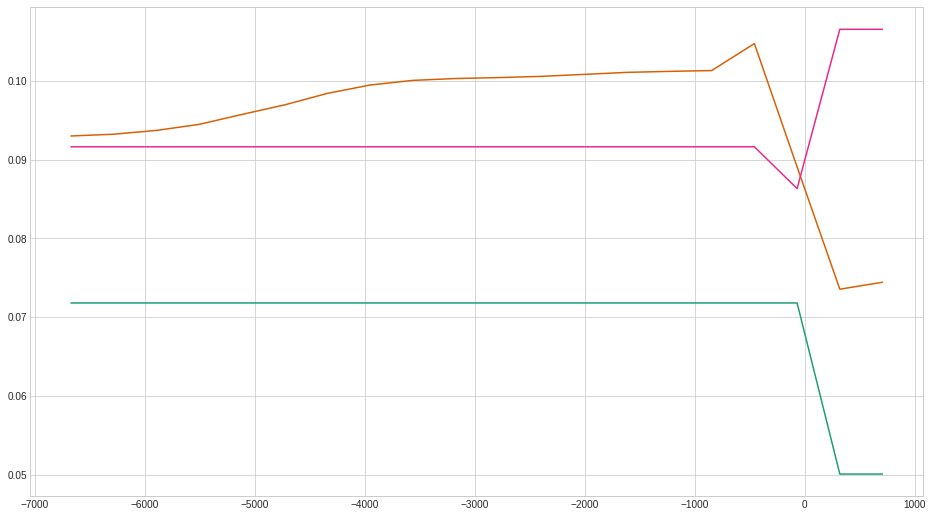

In [ ]:
aml.explain(test)

In [ ]:
!pip install mne
import mne

     |████████████████████████████████| 6.9 MB 5.4 MB/s 


## **RAW MNE**

In [ ]:
for eeg in eeg_list:
  eeg.drop(labels = ["Trigger","LDA-Output"], axis = 1, inplace = True)

In [ ]:
eeg_list[3]

,PO7,PO3,POz,PO4,PO8,O1,Oz,O2,Event
0,-85.981537,-553.993164,303.872742,-56.809189,-487.070251,-165.701904,135.098892,-801.984131,0
1,-457.985626,-1912.881470,1232.419434,-201.222427,-2161.820068,-471.416473,1116.425293,-3226.739990,0
2,-1061.565430,-1519.074951,1774.364624,-182.311615,-3817.674561,53.352119,3720.987061,-4566.417480,0
3,-1497.568481,2366.425781,844.814453,181.358978,-3651.555908,1819.778198,7095.944824,-2040.714355,0
4,-1638.541748,6094.715820,-321.388855,539.664429,-2906.458496,3295.383301,9416.365234,950.510559,0
...,...,...,...,...,...,...,...,...,...
57692,-7.339821,1.222771,3.389736,10.630192,5.421735,-12.867040,9.760956,4.420230,0
57693,-1.628320,6.624181,5.168508,6.914836,2.934678,-0.394954,15.169564,1.625323,0
57694,-6.124949,4.528360,1.870061,0.257741,-2.222052,-2.890369,11.295901,-5.169265,0
57695,-18.818218,-6.786640,-7.873328,-5.966027,-7.592616,-23.567797,-5.511063,-13.207706,0


In [ ]:
# create MNE of all subjects
raw_eeg_list = []
for eeg in eeg_list:
  sfreq = 256
  ch_names = eeg.columns.tolist()
  ch_types = ["eeg"]*8
  ch_types.append("stim")
  info = mne.create_info(ch_names = ch_names, ch_types = ch_types, sfreq = sfreq)
  info.set_montage("standard_1020")
  samples = eeg.T
  raw = mne.io.RawArray(samples, info)
  raw_eeg_list.append(raw)

Creating RawArray with float64 data, n_channels=9, n_times=57728
    Range : 0 ... 57727 =      0.000 ...   225.496 secs
Ready.
Creating RawArray with float64 data, n_channels=9, n_times=58112
    Range : 0 ... 58111 =      0.000 ...   226.996 secs
Ready.
Creating RawArray with float64 data, n_channels=9, n_times=58757
    Range : 0 ... 58756 =      0.000 ...   229.516 secs
Ready.
Creating RawArray with float64 data, n_channels=9, n_times=57697
    Range : 0 ... 57696 =      0.000 ...   225.375 secs
Ready.


In [ ]:
sfreq = 256
ch_names = eeg_list[0].columns.tolist()
ch_types = ["eeg"]*8
ch_types.append("stim")
info = mne.create_info(ch_names = ch_names, ch_types = ch_types, sfreq = sfreq)
info.set_montage("standard_1020")
samples = eeg_list[0].T
raw = mne.io.RawArray(samples, info)

Creating RawArray with float64 data, n_channels=9, n_times=57728
    Range : 0 ... 57727 =      0.000 ...   225.496 secs
Ready.


Effective window size : 8.000 (s)


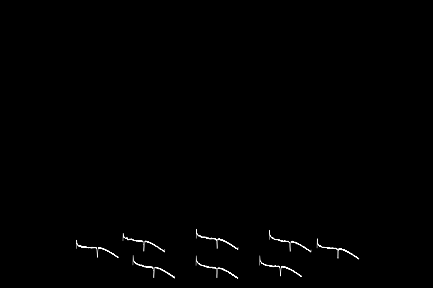

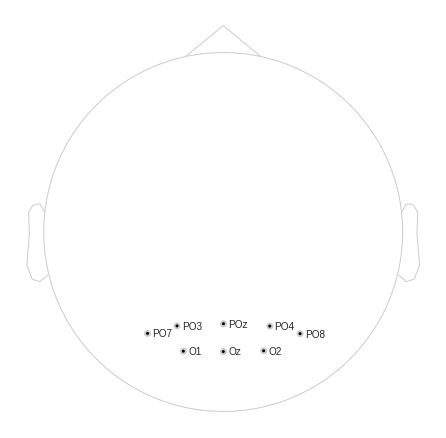

In [ ]:
raw.plot_psd_topo();
raw.plot_sensors(show_names=True);

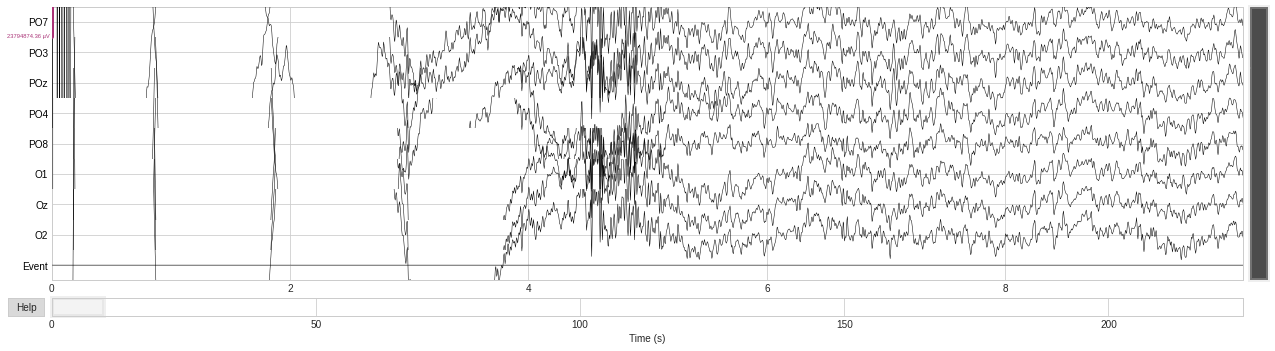

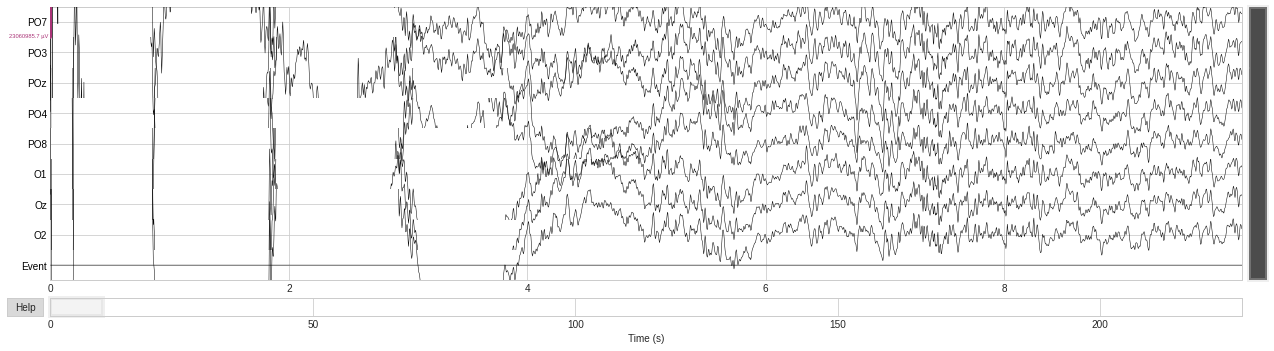

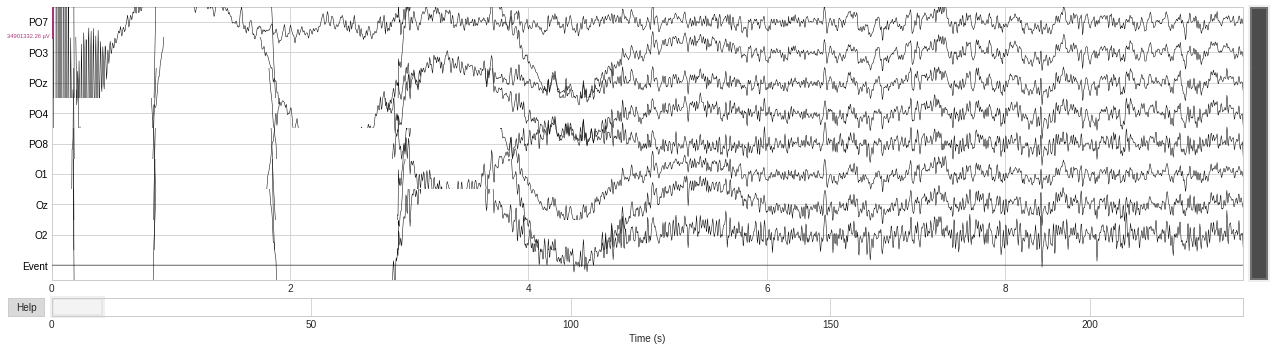

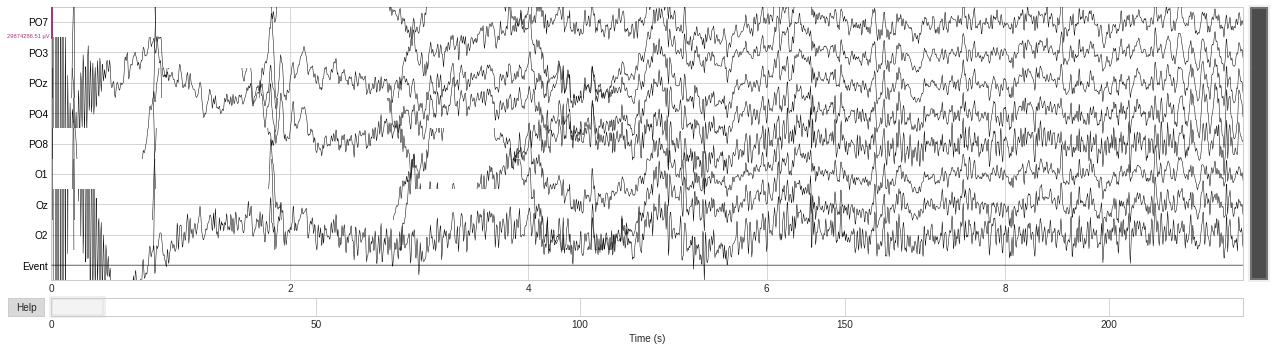

In [ ]:
plt.rcParams['figure.figsize'] = [18,5] #Fig settings:
for eeg in raw_eeg_list:
    eeg.plot(scalings="auto");

Effective window size : 8.000 (s)


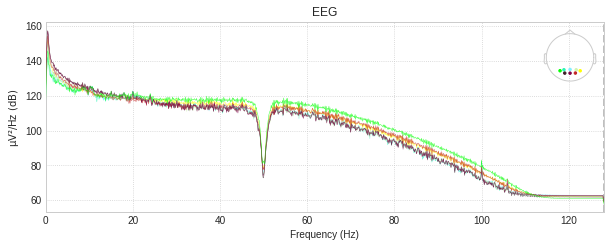

Effective window size : 8.000 (s)


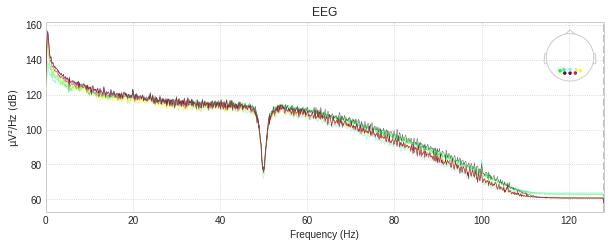

Effective window size : 8.000 (s)


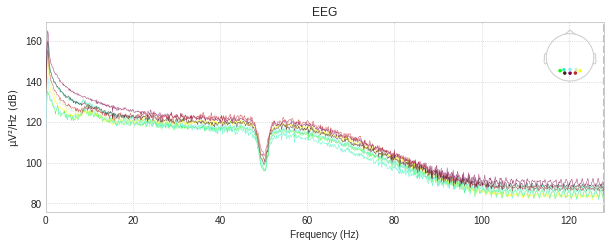

Effective window size : 8.000 (s)


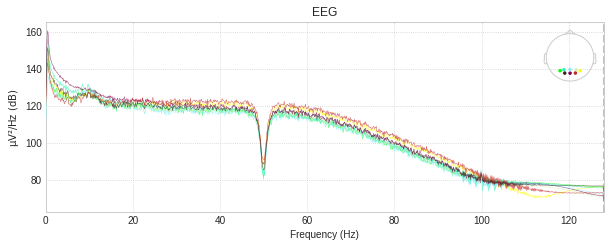

In [ ]:
for eeg in raw_eeg_list:
    eeg.plot_psd();

<Figure size 1296x360 with 0 Axes>

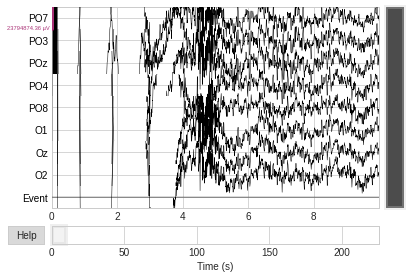

In [ ]:
plt.figure(figsize=(18,5))
raw.plot(scalings="auto");

In [ ]:
epochs_list = []
for raw in raw_eeg_list:
  events = mne.find_events(raw, stim_channel = "Event")
  print(events)
  event_dict = {"Freq_15":15,  "Freq_12":12, "Freq_10":10, "Freq_9":9}
  epochs = mne.Epochs(raw, events, tmin=0, tmax = 7, baseline=(0,0), event_id=event_dict)
  epochs_list.append(epochs)

20 events found
Event IDs: [ 9 10 12 15]
[[ 2560     0    15]
 [ 5248     0    12]
 [ 7936     0    10]
 [10624     0     9]
 [13312     0    15]
 [16000     0    12]
 [18688     0    10]
 [21376     0     9]
 [24064     0    15]
 [26752     0    12]
 [29440     0    10]
 [32128     0     9]
 [34816     0    15]
 [37504     0    12]
 [40192     0    10]
 [42880     0     9]
 [45568     0    15]
 [48256     0    12]
 [50944     0    10]
 [53632     0     9]]
Not setting metadata
Not setting metadata
20 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
20 events found
Event IDs: [ 9 10 12 15]
[[ 2560     0    15]
 [ 5248     0    12]
 [ 7936     0    10]
 [10624     0     9]
 [13312     0    15]
 [16000     0    12]
 [18688     0    10]
 [21376     0     9]
 [24064     0    15]
 [26752     0    12]
 [29440     0    10]
 [32128     0     9]
 [34816     0    15]
 [37504     0    12]
 [40192     0    10]
 [42880     0     9]
 [45568     0    15]
 [

In [ ]:
events = mne.find_events(raw, stim_channel = "Event")
print(events)
event_dict = {"Freq_15":15,  "Freq_12":12, "Freq_10":10, "Freq_9":9}
epochs = mne.Epochs(raw, events, tmin=-0.2, tmax = 7, event_id=event_dict)

20 events found
Event IDs: [ 9 10 12 15]
[[ 2560     0    15]
 [ 5248     0    12]
 [ 7936     0    10]
 [10624     0     9]
 [13312     0    15]
 [16000     0    12]
 [18688     0    10]
 [21376     0     9]
 [24064     0    15]
 [26752     0    12]
 [29440     0    10]
 [32128     0     9]
 [34816     0    15]
 [37504     0    12]
 [40192     0    10]
 [42880     0     9]
 [45568     0    15]
 [48256     0    12]
 [50944     0    10]
 [53632     0     9]]
Not setting metadata
Not setting metadata
20 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated


In [ ]:
epochs2 = mne.Epochs(raw, events, tmin=0, tmax = 7, baseline=(0,0),event_id=event_dict)

Not setting metadata
Not setting metadata
20 matching events found
Applying baseline correction (mode: mean)
0 projection items activated


Loading data for 5 events and 1844 original time points ...
0 bad epochs dropped
Loading data for 5 events and 1844 original time points ...
Loading data for 5 events and 1844 original time points ...


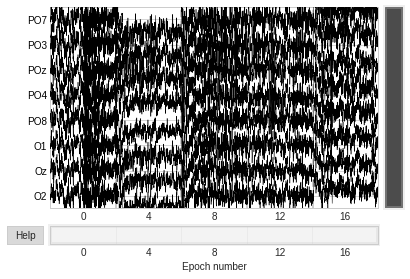

In [ ]:
epochs["Freq_15"].plot(scalings="auto", event_id = event_dict);

In [ ]:
epochs.plot_projs_topomap(vlim='joint')

ZeroDivisionError: ignored

Loading data for 5 events and 1844 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows


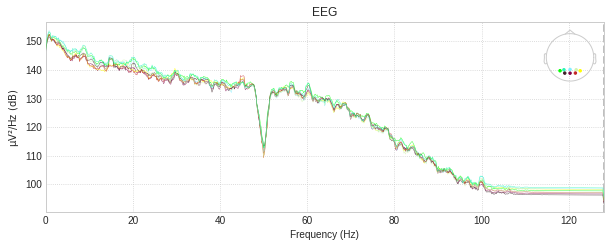

In [ ]:
epochs['Freq_15'].plot_psd(picks='eeg');

Loading data for 5 events and 1844 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows


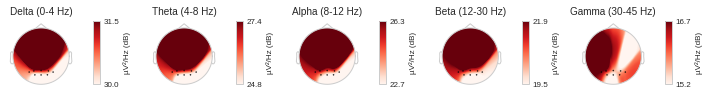

In [ ]:
epochs['Freq_15'].plot_psd_topomap();

Loading data for 5 events and 1844 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
5 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "mean"


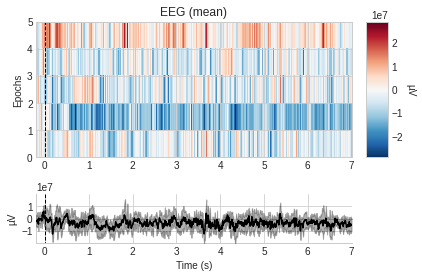

In [ ]:
epochs['Freq_15'].plot_image(picks='eeg', combine="mean");

Loading data for 5 events and 1844 original time points ...
Not setting metadata
Not setting metadata
5 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "gfp"


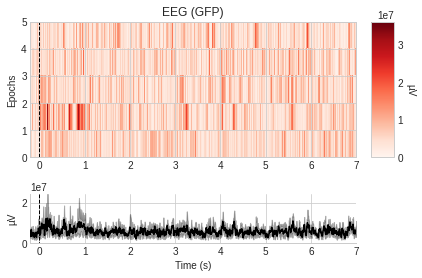

In [ ]:
epochs["Freq_10"].plot_image(picks='eeg', combine="gfp"); #global field power


In [ ]:
epoch_df = epochs.to_data_frame()
epoch_df

Loading data for 20 events and 1844 original time points ...


,time,condition,epoch,PO7,PO3,POz,PO4,PO8,O1,Oz,O2,Event
0,-199,Freq_15,0,-2.607359e+06,-3.498986e+06,-3.627225e+06,-3.493073e+06,7.385243e+05,-2.666377e+06,-2.585026e+06,-3.130537e+06,0.0
1,-195,Freq_15,0,-1.879218e+06,-2.811301e+06,-2.767753e+06,-3.449778e+06,-1.216434e+06,-2.040244e+06,-2.218430e+06,-4.284270e+06,0.0
2,-191,Freq_15,0,-2.757456e+06,-3.043795e+06,-2.327806e+06,-2.883662e+06,-1.794783e+06,-2.258219e+06,-2.728430e+06,-5.026850e+06,0.0
3,-188,Freq_15,0,-5.143238e+06,-4.576170e+06,-3.369277e+06,-3.113101e+06,-1.825789e+06,-3.597266e+06,-3.963818e+06,-5.507052e+06,0.0
4,-184,Freq_15,0,-6.453773e+06,-6.414784e+06,-4.494117e+06,-2.961676e+06,-1.378868e+06,-5.134114e+06,-4.887735e+06,-5.383514e+06,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
36875,6984,Freq_9,19,2.645739e+06,-5.096549e+06,-2.124182e+06,1.104467e+06,3.781690e+06,8.910913e+05,-2.791357e+05,4.364971e+06,9.0
36876,6988,Freq_9,19,4.833417e+06,-1.824266e+06,-1.219368e+06,-5.570351e+05,2.168889e+06,2.029720e+06,4.333713e+04,3.309385e+06,9.0
36877,6992,Freq_9,19,5.607392e+06,1.110631e+06,-4.111642e+05,-3.112271e+06,4.060906e+05,4.502501e+06,1.564919e+06,3.086388e+06,9.0
36878,6996,Freq_9,19,6.093624e+06,2.924135e+06,5.976710e+05,-3.691464e+06,8.776399e+05,7.753274e+06,3.698674e+06,4.602887e+06,9.0


In [ ]:
epochs["Freq_15"].to_data_frame()

Loading data for 5 events and 1844 original time points ...


,time,condition,epoch,PO7,PO3,POz,PO4,PO8,O1,Oz,O2,Event
0,-199,Freq_15,0,-2.607359e+06,-3.498986e+06,-3.627225e+06,-3.493073e+06,7.385243e+05,-2.666377e+06,-2.585026e+06,-3.130537e+06,0.0
1,-195,Freq_15,0,-1.879218e+06,-2.811301e+06,-2.767753e+06,-3.449778e+06,-1.216434e+06,-2.040244e+06,-2.218430e+06,-4.284270e+06,0.0
2,-191,Freq_15,0,-2.757456e+06,-3.043795e+06,-2.327806e+06,-2.883662e+06,-1.794783e+06,-2.258219e+06,-2.728430e+06,-5.026850e+06,0.0
3,-188,Freq_15,0,-5.143238e+06,-4.576170e+06,-3.369277e+06,-3.113101e+06,-1.825789e+06,-3.597266e+06,-3.963818e+06,-5.507052e+06,0.0
4,-184,Freq_15,0,-6.453773e+06,-6.414784e+06,-4.494117e+06,-2.961676e+06,-1.378868e+06,-5.134114e+06,-4.887735e+06,-5.383514e+06,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
9215,6984,Freq_15,16,2.661716e+06,1.528994e+06,-9.936127e+05,-2.287435e+06,-4.102805e+05,2.949068e+05,-2.276103e+06,-3.262739e+06,15.0
9216,6988,Freq_15,16,5.691410e+06,4.892468e+06,1.920507e+06,-1.325283e+06,1.197309e+06,2.513420e+06,-7.432414e+05,-1.408569e+06,15.0
9217,6992,Freq_15,16,5.889007e+06,6.572389e+06,3.887096e+06,-1.575400e+06,9.412429e+05,3.440750e+06,-9.482058e+04,-6.378238e+05,15.0
9218,6996,Freq_15,16,4.599599e+06,6.608859e+06,4.225478e+06,-2.523595e+06,-3.768256e+05,3.932683e+06,5.030963e+05,-5.104224e+05,15.0


In [ ]:
def clean_epoch():
  df_list = []
  labels = ["Freq_15",	"Freq_12",	"Freq_10",	"Freq_9"]
  for i in labels:
    epoch2_df = epochs2[i].to_data_frame()
    # epoch2_df
    # epoch2_df["Event"].replace({0.0:"No_Target", 15.0 : "Freq_15", 9.0:"Freq_9", 10.0: "Freq_10", 12.0:"Freq_12"}, inplace = True)
    # epoch2_df["Event"].replace({15.0 : "Freq_15"}, inplace = True)
    epoch2_df.drop(labels=["time","condition","epoch","Event"], axis=1, inplace=True)
    epoch2_df = epoch2_df.T
    epoch2_df["Label"] = i
    df_list.append(epoch2_df)
    df_final = pd.concat(df_list)
  return df_final



In [ ]:
def clean_epochs(data):
  df_list = []
  labels = ["Freq_15",	"Freq_12",	"Freq_10",	"Freq_9"]
  for i in labels:
    epoch2_df = data[i].to_data_frame()
    # epoch2_df
    # epoch2_df["Event"].replace({0.0:"No_Target", 15.0 : "Freq_15", 9.0:"Freq_9", 10.0: "Freq_10", 12.0:"Freq_12"}, inplace = True)
    # epoch2_df["Event"].replace({15.0 : "Freq_15"}, inplace = True)
    epoch2_df.drop(labels=["time","condition","epoch","Event"], axis=1, inplace=True)
    epoch2_df = epoch2_df.T
    epoch2_df["Label"] = i
    df_list.append(epoch2_df)
    df_final = pd.concat(df_list)
  return df_final


In [ ]:
s1_df = clean_epoch()
s1_df

Loading data for 5 events and 1793 original time points ...
Loading data for 5 events and 1793 original time points ...
Loading data for 5 events and 1793 original time points ...
Loading data for 5 events and 1793 original time points ...


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,8926,8927,8928,8929,8930,8931,8932,8933,8934,8935,8936,8937,8938,8939,8940,8941,8942,8943,8944,8945,8946,8947,8948,8949,8950,8951,8952,8953,8954,8955,8956,8957,8958,8959,8960,8961,8962,8963,8964,Label
PO7,0.0,1.576036e+06,-9.259185e+05,-3.553917e+06,-2.689906e+06,2.030424e+05,2.344183e+06,4.101622e+06,6.657560e+06,8.063876e+06,5.430221e+06,-8.607358e+04,-4.787824e+06,-8.118486e+06,-1.100758e+07,-1.218238e+07,-1.138617e+07,-1.007698e+07,-8.025348e+06,-5.263320e+06,-4.457170e+06,-6.137820e+06,-7.151488e+06,-6.983368e+06,-8.425464e+06,-1.168821e+07,-1.287833e+07,-9.950646e+06,-6.920381e+06,-7.231600e+06,-8.919141e+06,-9.805413e+06,-9.339686e+06,-6.284997e+06,-1.378117e+06,1.999166e+06,3.330436e+06,4.579844e+06,5.319854e+06,4.687109e+06,...,-1.438557e+07,-1.381104e+07,-1.276839e+07,-1.609868e+07,-2.185152e+07,-2.238835e+07,-1.717709e+07,-1.281432e+07,-1.226234e+07,-1.336588e+07,-1.483484e+07,-1.707799e+07,-1.879440e+07,-1.828972e+07,-1.643650e+07,-1.421014e+07,-1.202639e+07,-1.202638e+07,-1.451970e+07,-1.628788e+07,-1.606632e+07,-1.491375e+07,-1.282545e+07,-1.067913e+07,-1.091375e+07,-1.371475e+07,-1.701177e+07,-1.950169e+07,-2.049467e+07,-1.996765e+07,-1.948638e+07,-2.007101e+07,-2.024660e+07,-1.790822e+07,-1.367716e+07,-1.064747e+07,-1.044987e+07,-1.173928e+07,-1.316033e+07,Freq_15
PO3,0.0,1.223939e+06,2.736633e+05,-3.775501e+05,1.761958e+06,4.591500e+06,5.840474e+06,7.220848e+06,9.304439e+06,9.631333e+06,7.381839e+06,4.087330e+06,1.158352e+06,-1.173948e+06,-3.471868e+06,-5.815184e+06,-7.115134e+06,-6.408965e+06,-4.204702e+06,-2.018338e+06,-1.579803e+06,-2.937121e+06,-4.311779e+06,-5.436223e+06,-6.985091e+06,-8.066262e+06,-7.312535e+06,-5.665649e+06,-6.473168e+06,-9.779722e+06,-1.105358e+07,-8.857859e+06,-5.882083e+06,-2.560832e+06,1.405441e+06,3.594655e+06,4.169292e+06,6.565118e+06,9.631351e+06,8.517213e+06,...,-1.380767e+07,-1.652856e+07,-1.742120e+07,-1.890310e+07,-2.239811e+07,-2.366414e+07,-2.038848e+07,-1.701289e+07,-1.706180e+07,-1.766993e+07,-1.632875e+07,-1.572097e+07,-1.782985e+07,-2.048169e+07,-2.063514e+07,-1.719404e+07,-1.355258e+07,-1.445940e+07,-1.759833e+07,-1.781606e+07,-1.668661e+07,-1.686932e+07,-1.621531e+07,-1.428712e+07,-1.435848e+07,-1.700514e+07,-1.932414e+07,-1.996257e+07,-2.045223e+07,-2.206421e+07,-2.349381e+07,-2.331507e+07,-2.196394e+07,-1.952561e+07,-1.595702e+07,-1.259355e+07,-1.091362e+07,-1.087716e+07,-1.099502e+07,Freq_15
POz,0.0,2.101303e+06,1.800026e+06,5.483967e+05,1.319757e+06,3.722598e+06,5.502959e+06,7.022393e+06,9.804343e+06,1.198629e+07,1.010593e+07,4.812651e+06,4.714277e+05,-1.017273e+06,-1.447119e+06,-1.828087e+06,-1.871285e+06,-2.183947e+06,-2.681430e+06,-2.137900e+06,-1.723726e+06,-3.619145e+06,-6.864817e+06,-9.683826e+06,-1.180484e+07,-1.286072e+07,-1.194058e+07,-9.078106e+06,-6.595225e+06,-6.389076e+06,-6.743472e+06,-5.990575e+06,-5.506516e+06,-5.315806e+06,-3.649694e+06,-1.480327e+06,2.069642e+05,2.937662e+06,5.916424e+06,6.159074e+06,...,-1.606995e+07,-1.670022e+07,-1.531814e+07,-1.683056e+07,-2.156510e+07,-2.263231e+07,-1.810724e+07,-1.459973e+07,-1.550481e+07,-1.651402e+07,-1.523714e+07,-1.515473e+07,-1.771121e+07,-1.986648e+07,-1.944233e+07,-1.685726e+07,-1.460665e+07,-1.506793e+07,-1.642264e+07,-1.615600e+07,-1.615727e+07,-1.738232e+07,-1.690820e+07,-1.453990e+07,-1.395972e+07,-1.656204e+07,-1.999337e+07,-2.168469e+07,-2.112343e+07,-1.990572e+07,-1.969992e+07,-2.042688e+07,-2.086193e+07,-1.991012e+07,-1.750838e+07,-1.459426e+07,-1.262768e+07,-1.228929e+07,-1.223997e+07,Freq_15
PO4,0.0,3.714202e+06,5.427997e+06,5.144287e+06,5.137167e+06,5.540939e+06,5.351273e+06,5.768347e+06,8.721261e+06,1.218872e+07,1.171142e+07,7.078898e+06,3.017163e+06,2.311335e+06,3.187988e+06,3.957698e+06,4.075622e+06,2.308111e+06,-7.019105e+05,-2.180560e+06,-2.269650e+06,-3.476835e+06,-5.486279e+06,-6.240425e+06,-5.862288e+06,-5.753596e+06,-5.237266e+06,-2.977436e+06,-1.398036e+06,-3.184956e

In [ ]:
epochs_cleaned = []
for epoch in epochs_list:
  c_df = clean_epochs(epoch)
  epochs_cleaned.append(c_df)

Loading data for 5 events and 1793 original time points ...
0 bad epochs dropped
Loading data for 5 events and 1793 original time points ...
0 bad epochs dropped
Loading data for 5 events and 1793 original time points ...
0 bad epochs dropped
Loading data for 5 events and 1793 original time points ...
0 bad epochs dropped
Loading data for 5 events and 1793 original time points ...
0 bad epochs dropped
Loading data for 5 events and 1793 original time points ...
0 bad epochs dropped
Loading data for 5 events and 1793 original time points ...
0 bad epochs dropped
Loading data for 5 events and 1793 original time points ...
0 bad epochs dropped
Loading data for 5 events and 1793 original time points ...
0 bad epochs dropped
Loading data for 5 events and 1793 original time points ...
0 bad epochs dropped
Loading data for 5 events and 1793 original time points ...
0 bad epochs dropped
Loading data for 5 events and 1793 original time points ...
0 bad epochs dropped
Loading data for 5 events an

In [ ]:
# Principal Component Analysis
def get_pca(data):
  '''
    Args:
    data (pandas)
    Returns: 
     (numpy.array) PCA matrix
  '''
  n_components = min(data.shape)
  pca = PCA(n_components = n_components)
  pca_transformed_data = pca.fit_transform(data)
  return pca_transformed_data, pca

def plot_pca(data):
  """
  Args:
    data (list): list with exaplained variance values
  """
  plt.figure(figsize=(18,5))
  x = range(len(data.explained_variance_))
  plt.plot(x, data.explained_variance_, "o-")
  plt.title("PCA")
  plt.xlabel("Components")
  plt.ylabel("Variance Explained")

def standarize(data):
  sc = StandardScaler()
  transformed = sc.fit_transform(data)
  return transformed

In [ ]:
epoch2_df = epochs2["Freq_15"].to_data_frame()
epoch2_df
# epoch2_df["Event"].replace({0.0:"No_Target", 15.0 : "Freq_15", 9.0:"Freq_9", 10.0: "Freq_10", 12.0:"Freq_12"}, inplace = True)
# epoch2_df["Event"].replace({15.0 : "Freq_15"}, inplace = True)
epoch2_df.drop(labels=["time","condition","epoch","Event"], axis=1, inplace=True)
epoch2_df = epoch2_df.T
epoch2_df["Label"] = "Freq_15"
epoch2_df

Loading data for 5 events and 1793 original time points ...


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,8926,8927,8928,8929,8930,8931,8932,8933,8934,8935,8936,8937,8938,8939,8940,8941,8942,8943,8944,8945,8946,8947,8948,8949,8950,8951,8952,8953,8954,8955,8956,8957,8958,8959,8960,8961,8962,8963,8964,Label
PO7,0.0,1.576036e+06,-9.259185e+05,-3.553917e+06,-2.689906e+06,2.030424e+05,2.344183e+06,4.101622e+06,6.657560e+06,8.063876e+06,5.430221e+06,-8.607358e+04,-4.787824e+06,-8.118486e+06,-1.100758e+07,-1.218238e+07,-1.138617e+07,-1.007698e+07,-8.025348e+06,-5.263320e+06,-4.457170e+06,-6.137820e+06,-7.151488e+06,-6.983368e+06,-8.425464e+06,-1.168821e+07,-1.287833e+07,-9.950646e+06,-6.920381e+06,-7.231600e+06,-8.919141e+06,-9.805413e+06,-9.339686e+06,-6.284997e+06,-1.378117e+06,1.999166e+06,3.330436e+06,4.579844e+06,5.319854e+06,4.687109e+06,...,-1.438557e+07,-1.381104e+07,-1.276839e+07,-1.609868e+07,-2.185152e+07,-2.238835e+07,-1.717709e+07,-1.281432e+07,-1.226234e+07,-1.336588e+07,-1.483484e+07,-1.707799e+07,-1.879440e+07,-1.828972e+07,-1.643650e+07,-1.421014e+07,-1.202639e+07,-1.202638e+07,-1.451970e+07,-1.628788e+07,-1.606632e+07,-1.491375e+07,-1.282545e+07,-1.067913e+07,-1.091375e+07,-1.371475e+07,-1.701177e+07,-1.950169e+07,-2.049467e+07,-1.996765e+07,-1.948638e+07,-2.007101e+07,-2.024660e+07,-1.790822e+07,-1.367716e+07,-1.064747e+07,-1.044987e+07,-1.173928e+07,-1.316033e+07,Freq_15
PO3,0.0,1.223939e+06,2.736633e+05,-3.775501e+05,1.761958e+06,4.591500e+06,5.840474e+06,7.220848e+06,9.304439e+06,9.631333e+06,7.381839e+06,4.087330e+06,1.158352e+06,-1.173948e+06,-3.471868e+06,-5.815184e+06,-7.115134e+06,-6.408965e+06,-4.204702e+06,-2.018338e+06,-1.579803e+06,-2.937121e+06,-4.311779e+06,-5.436223e+06,-6.985091e+06,-8.066262e+06,-7.312535e+06,-5.665649e+06,-6.473168e+06,-9.779722e+06,-1.105358e+07,-8.857859e+06,-5.882083e+06,-2.560832e+06,1.405441e+06,3.594655e+06,4.169292e+06,6.565118e+06,9.631351e+06,8.517213e+06,...,-1.380767e+07,-1.652856e+07,-1.742120e+07,-1.890310e+07,-2.239811e+07,-2.366414e+07,-2.038848e+07,-1.701289e+07,-1.706180e+07,-1.766993e+07,-1.632875e+07,-1.572097e+07,-1.782985e+07,-2.048169e+07,-2.063514e+07,-1.719404e+07,-1.355258e+07,-1.445940e+07,-1.759833e+07,-1.781606e+07,-1.668661e+07,-1.686932e+07,-1.621531e+07,-1.428712e+07,-1.435848e+07,-1.700514e+07,-1.932414e+07,-1.996257e+07,-2.045223e+07,-2.206421e+07,-2.349381e+07,-2.331507e+07,-2.196394e+07,-1.952561e+07,-1.595702e+07,-1.259355e+07,-1.091362e+07,-1.087716e+07,-1.099502e+07,Freq_15
POz,0.0,2.101303e+06,1.800026e+06,5.483967e+05,1.319757e+06,3.722598e+06,5.502959e+06,7.022393e+06,9.804343e+06,1.198629e+07,1.010593e+07,4.812651e+06,4.714277e+05,-1.017273e+06,-1.447119e+06,-1.828087e+06,-1.871285e+06,-2.183947e+06,-2.681430e+06,-2.137900e+06,-1.723726e+06,-3.619145e+06,-6.864817e+06,-9.683826e+06,-1.180484e+07,-1.286072e+07,-1.194058e+07,-9.078106e+06,-6.595225e+06,-6.389076e+06,-6.743472e+06,-5.990575e+06,-5.506516e+06,-5.315806e+06,-3.649694e+06,-1.480327e+06,2.069642e+05,2.937662e+06,5.916424e+06,6.159074e+06,...,-1.606995e+07,-1.670022e+07,-1.531814e+07,-1.683056e+07,-2.156510e+07,-2.263231e+07,-1.810724e+07,-1.459973e+07,-1.550481e+07,-1.651402e+07,-1.523714e+07,-1.515473e+07,-1.771121e+07,-1.986648e+07,-1.944233e+07,-1.685726e+07,-1.460665e+07,-1.506793e+07,-1.642264e+07,-1.615600e+07,-1.615727e+07,-1.738232e+07,-1.690820e+07,-1.453990e+07,-1.395972e+07,-1.656204e+07,-1.999337e+07,-2.168469e+07,-2.112343e+07,-1.990572e+07,-1.969992e+07,-2.042688e+07,-2.086193e+07,-1.991012e+07,-1.750838e+07,-1.459426e+07,-1.262768e+07,-1.228929e+07,-1.223997e+07,Freq_15
PO4,0.0,3.714202e+06,5.427997e+06,5.144287e+06,5.137167e+06,5.540939e+06,5.351273e+06,5.768347e+06,8.721261e+06,1.218872e+07,1.171142e+07,7.078898e+06,3.017163e+06,2.311335e+06,3.187988e+06,3.957698e+06,4.075622e+06,2.308111e+06,-7.019105e+05,-2.180560e+06,-2.269650e+06,-3.476835e+06,-5.486279e+06,-6.240425e+06,-5.862288e+06,-5.753596e+06,-5.237266e+06,-2.977436e+06,-1.398036e+06,-3.184956e

In [ ]:
epochs_cleaned[0]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,8926,8927,8928,8929,8930,8931,8932,8933,8934,8935,8936,8937,8938,8939,8940,8941,8942,8943,8944,8945,8946,8947,8948,8949,8950,8951,8952,8953,8954,8955,8956,8957,8958,8959,8960,8961,8962,8963,8964,Label
PO7,0.0,1.576036e+06,-9.259185e+05,-3.553917e+06,-2.689906e+06,2.030424e+05,2.344183e+06,4.101622e+06,6.657560e+06,8.063876e+06,5.430221e+06,-8.607358e+04,-4.787824e+06,-8.118486e+06,-1.100758e+07,-1.218238e+07,-1.138617e+07,-1.007698e+07,-8.025348e+06,-5.263320e+06,-4.457170e+06,-6.137820e+06,-7.151488e+06,-6.983368e+06,-8.425464e+06,-1.168821e+07,-1.287833e+07,-9.950646e+06,-6.920381e+06,-7.231600e+06,-8.919141e+06,-9.805413e+06,-9.339686e+06,-6.284997e+06,-1.378117e+06,1.999166e+06,3.330436e+06,4.579844e+06,5.319854e+06,4.687109e+06,...,-1.438557e+07,-1.381104e+07,-1.276839e+07,-1.609868e+07,-2.185152e+07,-2.238835e+07,-1.717709e+07,-1.281432e+07,-1.226234e+07,-1.336588e+07,-1.483484e+07,-1.707799e+07,-1.879440e+07,-1.828972e+07,-1.643650e+07,-1.421014e+07,-1.202639e+07,-1.202638e+07,-1.451970e+07,-1.628788e+07,-1.606632e+07,-1.491375e+07,-1.282545e+07,-1.067913e+07,-1.091375e+07,-1.371475e+07,-1.701177e+07,-1.950169e+07,-2.049467e+07,-1.996765e+07,-1.948638e+07,-2.007101e+07,-2.024660e+07,-1.790822e+07,-1.367716e+07,-1.064747e+07,-1.044987e+07,-1.173928e+07,-1.316033e+07,Freq_15
PO3,0.0,1.223939e+06,2.736633e+05,-3.775501e+05,1.761958e+06,4.591500e+06,5.840474e+06,7.220848e+06,9.304439e+06,9.631333e+06,7.381839e+06,4.087330e+06,1.158352e+06,-1.173948e+06,-3.471868e+06,-5.815184e+06,-7.115134e+06,-6.408965e+06,-4.204702e+06,-2.018338e+06,-1.579803e+06,-2.937121e+06,-4.311779e+06,-5.436223e+06,-6.985091e+06,-8.066262e+06,-7.312535e+06,-5.665649e+06,-6.473168e+06,-9.779722e+06,-1.105358e+07,-8.857859e+06,-5.882083e+06,-2.560832e+06,1.405441e+06,3.594655e+06,4.169292e+06,6.565118e+06,9.631351e+06,8.517213e+06,...,-1.380767e+07,-1.652856e+07,-1.742120e+07,-1.890310e+07,-2.239811e+07,-2.366414e+07,-2.038848e+07,-1.701289e+07,-1.706180e+07,-1.766993e+07,-1.632875e+07,-1.572097e+07,-1.782985e+07,-2.048169e+07,-2.063514e+07,-1.719404e+07,-1.355258e+07,-1.445940e+07,-1.759833e+07,-1.781606e+07,-1.668661e+07,-1.686932e+07,-1.621531e+07,-1.428712e+07,-1.435848e+07,-1.700514e+07,-1.932414e+07,-1.996257e+07,-2.045223e+07,-2.206421e+07,-2.349381e+07,-2.331507e+07,-2.196394e+07,-1.952561e+07,-1.595702e+07,-1.259355e+07,-1.091362e+07,-1.087716e+07,-1.099502e+07,Freq_15
POz,0.0,2.101303e+06,1.800026e+06,5.483967e+05,1.319757e+06,3.722598e+06,5.502959e+06,7.022393e+06,9.804343e+06,1.198629e+07,1.010593e+07,4.812651e+06,4.714277e+05,-1.017273e+06,-1.447119e+06,-1.828087e+06,-1.871285e+06,-2.183947e+06,-2.681430e+06,-2.137900e+06,-1.723726e+06,-3.619145e+06,-6.864817e+06,-9.683826e+06,-1.180484e+07,-1.286072e+07,-1.194058e+07,-9.078106e+06,-6.595225e+06,-6.389076e+06,-6.743472e+06,-5.990575e+06,-5.506516e+06,-5.315806e+06,-3.649694e+06,-1.480327e+06,2.069642e+05,2.937662e+06,5.916424e+06,6.159074e+06,...,-1.606995e+07,-1.670022e+07,-1.531814e+07,-1.683056e+07,-2.156510e+07,-2.263231e+07,-1.810724e+07,-1.459973e+07,-1.550481e+07,-1.651402e+07,-1.523714e+07,-1.515473e+07,-1.771121e+07,-1.986648e+07,-1.944233e+07,-1.685726e+07,-1.460665e+07,-1.506793e+07,-1.642264e+07,-1.615600e+07,-1.615727e+07,-1.738232e+07,-1.690820e+07,-1.453990e+07,-1.395972e+07,-1.656204e+07,-1.999337e+07,-2.168469e+07,-2.112343e+07,-1.990572e+07,-1.969992e+07,-2.042688e+07,-2.086193e+07,-1.991012e+07,-1.750838e+07,-1.459426e+07,-1.262768e+07,-1.228929e+07,-1.223997e+07,Freq_15
PO4,0.0,3.714202e+06,5.427997e+06,5.144287e+06,5.137167e+06,5.540939e+06,5.351273e+06,5.768347e+06,8.721261e+06,1.218872e+07,1.171142e+07,7.078898e+06,3.017163e+06,2.311335e+06,3.187988e+06,3.957698e+06,4.075622e+06,2.308111e+06,-7.019105e+05,-2.180560e+06,-2.269650e+06,-3.476835e+06,-5.486279e+06,-6.240425e+06,-5.862288e+06,-5.753596e+06,-5.237266e+06,-2.977436e+06,-1.398036e+06,-3.184956e

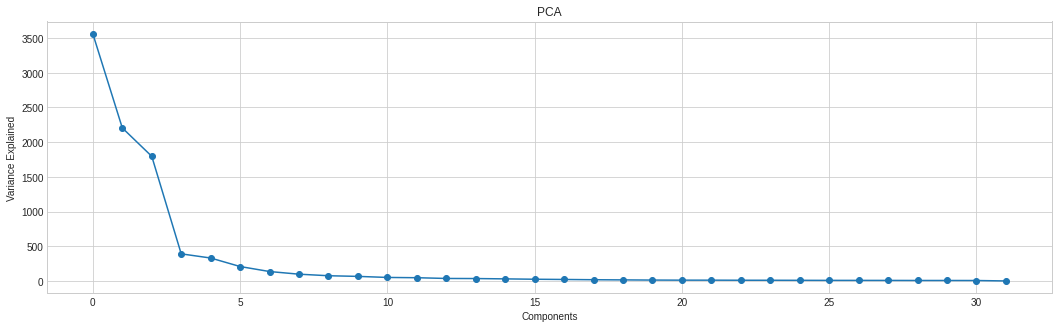

In [ ]:
z = standarize(s1_df.iloc[:,:-1])
z, pca = get_pca(z)
plot_pca(pca)

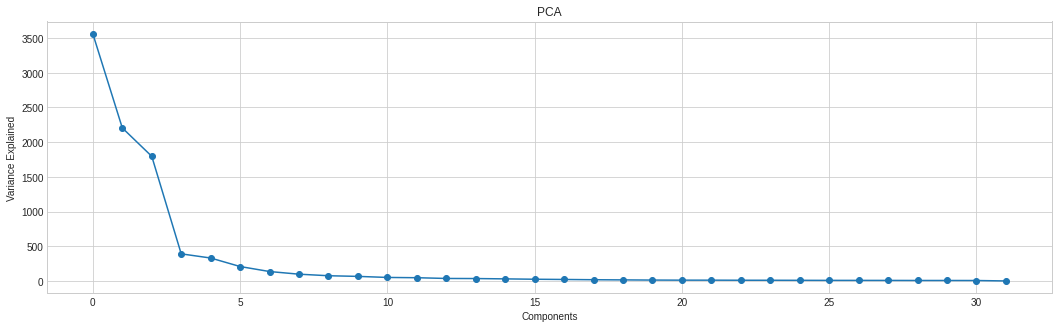

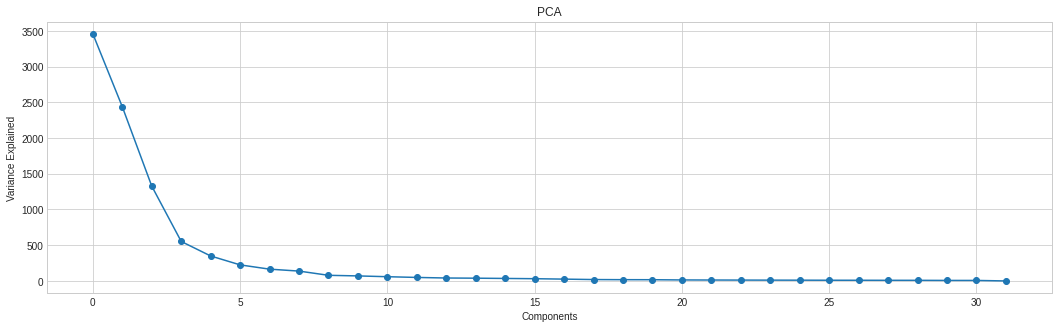

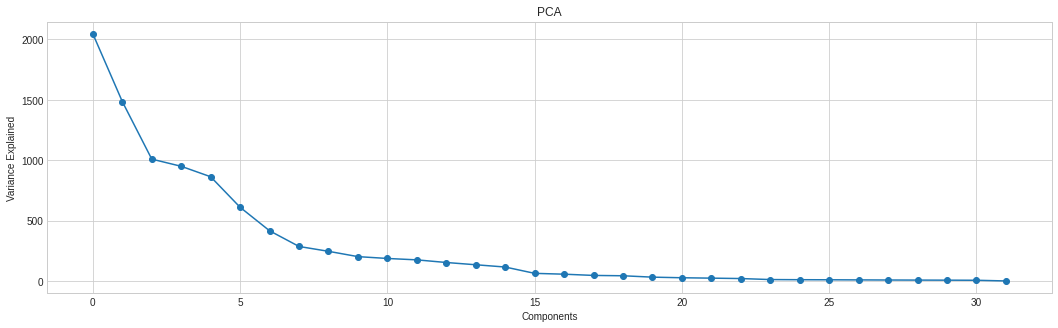

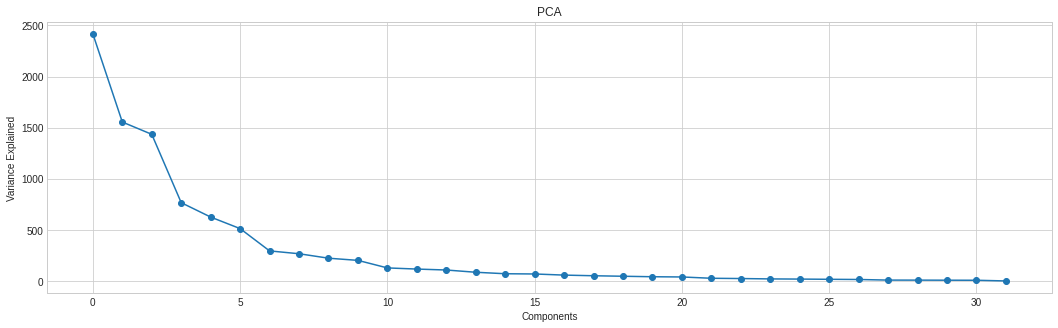

In [ ]:
pca_list = []
for eeg in epochs_cleaned:
  z = standarize(eeg.iloc[:,:-1])
  z, pca = get_pca(z)
  pca_list.append(z)
  plot_pca(pca)

In [ ]:
z.shape

(32, 32)

In [ ]:
s1_df.iloc[:,-1].tolist()

['Freq_15',
 'Freq_15',
 'Freq_15',
 'Freq_15',
 'Freq_15',
 'Freq_15',
 'Freq_15',
 'Freq_15',
 'Freq_12',
 'Freq_12',
 'Freq_12',
 'Freq_12',
 'Freq_12',
 'Freq_12',
 'Freq_12',
 'Freq_12',
 'Freq_10',
 'Freq_10',
 'Freq_10',
 'Freq_10',
 'Freq_10',
 'Freq_10',
 'Freq_10',
 'Freq_10',
 'Freq_9',
 'Freq_9',
 'Freq_9',
 'Freq_9',
 'Freq_9',
 'Freq_9',
 'Freq_9',
 'Freq_9']

In [ ]:
new_s1 = pd.DataFrame(z)
# print(new_s1.head())
new_s1["label"] = s1_df.iloc[:,-1].tolist()
new_s1

           0          1          2   ...        29        30            31
0   88.831270  -9.914725  23.900289  ... -0.998765  0.249476  3.099953e-14
1  102.732370  15.931822  30.664925  ...  0.160899  0.449410  3.099953e-14
2  116.169675   8.529079  12.262291  ... -0.084479 -0.191519  3.099953e-14
3  115.205253   8.433677   8.693675  ...  0.002796 -0.707507  3.099953e-14
4   94.418857  -5.927548  11.709099  ...  1.721051 -0.029112  3.099953e-14

[5 rows x 32 columns]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,label
0,88.831270,-9.914725,23.900289,22.973124,-21.184881,-18.671763,-1.316804,-14.473958,9.781490,-10.281989,7.846601,7.283421,-6.411036,-6.912846,5.668490,-5.237282,-8.885554,-8.821017,1.639579,-0.318905,-1.739617,2.800328,0.448895,-0.397380,1.312635,0.084874,-0.010231,-1.792084,-2.401249,-0.998765,0.249476,3.099953e-14,Freq_15
1,102.732370,15.931822,30.664925,11.744053,-24.354997,-13.175056,0.388035,-7.556089,14.817693,6.356235,-7.492434,-1.266763,-5.291648,-5.421745,4.567202,3.077737,12.282731,10.277646,1.601386,0.447679,1.534570,-0.504615,-1.684364,0.882159,-0.665732,0.952507,3.174864,-0.614067,-0.819894,0.160899,0.449410,3.099953e-14,Freq_15
2,116.169675,8.529079,12.262291,0.428642,6.520569,1.247314,0.213956,-4.905673,-0.268746,17.778380,-15.370816,-3.981719,-0.912183,6.961133,-3.446403,1.557107,-8.223756,-1.641428,1.675597,4.453628,-0.328267,-1.210190,1.342997,-7.774784,-3.553192,-0.025165,-2.850815,0.418839,-0.007724,-0.084479,-0.191519,3.099953e-14,Freq_15
3,115.205253,8.433677,8.693675,-21.915993,26.183467,11.884864,-1.188074,12.377572,-2.750357,9.814488,-9.768556,-2.472515,-4.679811,-1.635630,7.094597,-0.160238,-2.824331,-3.900070,-1.261210,-6.043296,-1.185168,1.374002,-0.012618,8.510601,4.469214,-0.393340,0.636916,0.927646,1.510773,0.002796,-0.707507,3.099953e-14,Freq_15
4,94.418857,-5.927548,11.709099,-29.215990,28.820621,5.698339,-4.694282,17.319484,-2.411224,-13.236726,10.857149,2.535088,-2.717281,-6.936605,5.797699,-0.320441,4.578588,2.259890,-0.550601,1.272270,2.232702,-2.460500,0.007689,-4.763977,-2.877540,-2.948088,-5.413064,-1.831199,-1.071901,1.721051,-0.029112,3.099953e-14,Freq_15
5,85.431119,4.966658,12.982997,20.010622,-12.473913,-10.476483,0.455384,-7.561442,2.194118,-3.250927,8.358077,-1.666966,7.055776,3.433787,-7.532752,-0.301892,3.950515,-2.642964,-5.137191,-0.319805,2.360674,-1.195564,0.639590,2.861409,-0.341123,-0.959487,-4.421694,5.104516,7.583385,1.096067,-2.499175,3.099953e-14,Freq_15
6,88.422439,4.425854,8.718244,21.961799,-6.227884,-3.181790,1.544109,0.524127,-12.940270,-1.213580,5.312132,-3.896642,11.588516,9.290939,-7.635230,0.872536,-0.269618,3.276239,-1.127103,-3.491677,-1.253881,-2.202398,-0.702304,2.343787,3.089452,-2.361247,-0.117978,-4.804419,-6.422003,1.097092,2.697772,3.099953e-14,Freq_15
7,89.372544,-6.012852,7.580132,-8.200600,20.258153,1.438648,0.340210,3.713685,-14.043736,-8.100778,7.985337,1.511574,3.705585,0.686119,-3.937993,-0.896887,-0.404472,2.213877,3.247910,4.706104,-1.861728,3.648722,0.340717,-1.003260,-1.358694,5.730437,8.527627,2.730866,1.716096,-2.896223,-0.178692,3.099953e-14,Freq_15
8,-17.916793,-70.980820,-42.317224,-5.232892,-4.456764,-9.831933,-22.418082,-5.350389,-11.684883,-3.372330,-10.272740,16.558548,-6.925646,-3.872349,-7.032870,1.409116,-0.973624,3.836038,-7.174638,-3.633697,-1.793039,-1.004965,3.068068,0.547328,-2.680583,-0.144028,0.195528,-0.566475,1.063108,-0.539061,2.328687,3.099953e-14,Freq_12
9,-26.411048,-68.462446,-61.870988,10.474651,-5.583078,-11.495189,-19.704028,3.935765,-6.543384,12.780986,6.145214,-1.277098,4.103872,-2.516376,6.074983,12.475784,5.640983,-8.750453,4.029820,4.299858,-0.717957,-0.171145,-0.453207,-0.236712,1.542432,-1.323396,1.025913,0.197490,-0.145637,1.557516,0.511116,3.099953e-14,Freq_12


In [ ]:
new_eegs_list = []
for pca in pca_list:
  new_eeg = pd.DataFrame(pca)
  new_eeg["label"] = eeg.iloc[:,-1].tolist()
  new_eegs_list.append(new_eeg)

In [ ]:
new_eegs_list[0]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,label
0,88.831270,-9.914725,23.900289,22.973124,-21.184881,-18.671763,-1.316804,-14.473958,9.781490,-10.281989,7.846601,7.283421,-6.411036,-6.912846,5.668490,-5.237282,-8.885554,-8.821017,1.639579,-0.318905,-1.739617,2.800328,0.448895,-0.397380,1.312635,0.084874,-0.010231,-1.792084,-2.401249,-0.998765,0.249476,3.099953e-14,Freq_15
1,102.732370,15.931822,30.664925,11.744053,-24.354997,-13.175056,0.388035,-7.556089,14.817693,6.356235,-7.492434,-1.266763,-5.291648,-5.421745,4.567202,3.077737,12.282731,10.277646,1.601386,0.447679,1.534570,-0.504615,-1.684364,0.882159,-0.665732,0.952507,3.174864,-0.614067,-0.819894,0.160899,0.449410,3.099953e-14,Freq_15
2,116.169675,8.529079,12.262291,0.428642,6.520569,1.247314,0.213956,-4.905673,-0.268746,17.778380,-15.370816,-3.981719,-0.912183,6.961133,-3.446403,1.557107,-8.223756,-1.641428,1.675597,4.453628,-0.328267,-1.210190,1.342997,-7.774784,-3.553192,-0.025165,-2.850815,0.418839,-0.007724,-0.084479,-0.191519,3.099953e-14,Freq_15
3,115.205253,8.433677,8.693675,-21.915993,26.183467,11.884864,-1.188074,12.377572,-2.750357,9.814488,-9.768556,-2.472515,-4.679811,-1.635630,7.094597,-0.160238,-2.824331,-3.900070,-1.261210,-6.043296,-1.185168,1.374002,-0.012618,8.510601,4.469214,-0.393340,0.636916,0.927646,1.510773,0.002796,-0.707507,3.099953e-14,Freq_15
4,94.418857,-5.927548,11.709099,-29.215990,28.820621,5.698339,-4.694282,17.319484,-2.411224,-13.236726,10.857149,2.535088,-2.717281,-6.936605,5.797699,-0.320441,4.578588,2.259890,-0.550601,1.272270,2.232702,-2.460500,0.007689,-4.763977,-2.877540,-2.948088,-5.413064,-1.831199,-1.071901,1.721051,-0.029112,3.099953e-14,Freq_15
5,85.431119,4.966658,12.982997,20.010622,-12.473913,-10.476483,0.455384,-7.561442,2.194118,-3.250927,8.358077,-1.666966,7.055776,3.433787,-7.532752,-0.301892,3.950515,-2.642964,-5.137191,-0.319805,2.360674,-1.195564,0.639590,2.861409,-0.341123,-0.959487,-4.421694,5.104516,7.583385,1.096067,-2.499175,3.099953e-14,Freq_15
6,88.422439,4.425854,8.718244,21.961799,-6.227884,-3.181790,1.544109,0.524127,-12.940270,-1.213580,5.312132,-3.896642,11.588516,9.290939,-7.635230,0.872536,-0.269618,3.276239,-1.127103,-3.491677,-1.253881,-2.202398,-0.702304,2.343787,3.089452,-2.361247,-0.117978,-4.804419,-6.422003,1.097092,2.697772,3.099953e-14,Freq_15
7,89.372544,-6.012852,7.580132,-8.200600,20.258153,1.438648,0.340210,3.713685,-14.043736,-8.100778,7.985337,1.511574,3.705585,0.686119,-3.937993,-0.896887,-0.404472,2.213877,3.247910,4.706104,-1.861728,3.648722,0.340717,-1.003260,-1.358694,5.730437,8.527627,2.730866,1.716096,-2.896223,-0.178692,3.099953e-14,Freq_15
8,-17.916793,-70.980820,-42.317224,-5.232892,-4.456764,-9.831933,-22.418082,-5.350389,-11.684883,-3.372330,-10.272740,16.558548,-6.925646,-3.872349,-7.032870,1.409116,-0.973624,3.836038,-7.174638,-3.633697,-1.793039,-1.004965,3.068068,0.547328,-2.680583,-0.144028,0.195528,-0.566475,1.063108,-0.539061,2.328687,3.099953e-14,Freq_12
9,-26.411048,-68.462446,-61.870988,10.474651,-5.583078,-11.495189,-19.704028,3.935765,-6.543384,12.780986,6.145214,-1.277098,4.103872,-2.516376,6.074983,12.475784,5.640983,-8.750453,4.029820,4.299858,-0.717957,-0.171145,-0.453207,-0.236712,1.542432,-1.323396,1.025913,0.197490,-0.145637,1.557516,0.511116,3.099953e-14,Freq_12


In [ ]:
eeg_to_ml = pd.concat(new_eegs_list)
eeg_to_ml

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,label
0,88.831270,-9.914725,23.900289,22.973124,-21.184881,-18.671763,-1.316804,-14.473958,9.781490,-10.281989,7.846601,7.283421,-6.411036,-6.912846,5.668490,-5.237282,-8.885554,-8.821017,1.639579,-0.318905,-1.739617,2.800328,0.448895,-0.397380,1.312635,0.084874,-0.010231,-1.792084,-2.401249,-0.998765,0.249476,3.099953e-14,Freq_15
1,102.732370,15.931822,30.664925,11.744053,-24.354997,-13.175056,0.388035,-7.556089,14.817693,6.356235,-7.492434,-1.266763,-5.291648,-5.421745,4.567202,3.077737,12.282731,10.277646,1.601386,0.447679,1.534570,-0.504615,-1.684364,0.882159,-0.665732,0.952507,3.174864,-0.614067,-0.819894,0.160899,0.449410,3.099953e-14,Freq_15
2,116.169675,8.529079,12.262291,0.428642,6.520569,1.247314,0.213956,-4.905673,-0.268746,17.778380,-15.370816,-3.981719,-0.912183,6.961133,-3.446403,1.557107,-8.223756,-1.641428,1.675597,4.453628,-0.328267,-1.210190,1.342997,-7.774784,-3.553192,-0.025165,-2.850815,0.418839,-0.007724,-0.084479,-0.191519,3.099953e-14,Freq_15
3,115.205253,8.433677,8.693675,-21.915993,26.183467,11.884864,-1.188074,12.377572,-2.750357,9.814488,-9.768556,-2.472515,-4.679811,-1.635630,7.094597,-0.160238,-2.824331,-3.900070,-1.261210,-6.043296,-1.185168,1.374002,-0.012618,8.510601,4.469214,-0.393340,0.636916,0.927646,1.510773,0.002796,-0.707507,3.099953e-14,Freq_15
4,94.418857,-5.927548,11.709099,-29.215990,28.820621,5.698339,-4.694282,17.319484,-2.411224,-13.236726,10.857149,2.535088,-2.717281,-6.936605,5.797699,-0.320441,4.578588,2.259890,-0.550601,1.272270,2.232702,-2.460500,0.007689,-4.763977,-2.877540,-2.948088,-5.413064,-1.831199,-1.071901,1.721051,-0.029112,3.099953e-14,Freq_15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,31.232016,-2.648637,48.369056,-8.529896,-20.272593,20.397904,7.267257,-40.565368,-1.502911,-2.941671,-1.244394,-6.517374,-9.684728,4.477232,-11.400428,0.815098,-3.297175,-3.582845,2.106955,1.314976,-1.764081,1.688826,1.901275,4.848166,-10.680118,-2.831868,-0.777412,-7.858055,1.632178,0.016423,-0.056267,3.050974e-14,Freq_9
28,35.963943,2.020928,56.375072,-7.253297,-16.688622,25.892025,21.516376,-23.760840,9.297418,1.648956,-5.455232,0.918884,-3.627864,-5.426592,0.350766,5.376832,-14.093237,3.447579,-12.564556,-12.884997,-7.260493,-8.540673,-2.150334,-0.679519,6.529173,2.285131,0.945921,3.949003,-0.554543,0.402107,-0.125486,3.050974e-14,Freq_9
29,2.535255,20.291265,67.694650,-17.485295,-18.603666,-33.224474,-12.085885,51.911857,-16.945040,1.220722,-14.632101,-17.062682,-15.068239,-6.598651,-14.615728,2.128206,-4.172552,-1.260684,-3.043464,2.367008,-4.997434,-1.358157,-0.426902,-1.580623,-0.336125,-0.177945,0.215615,-0.751310,-0.128836,-0.162643,-0.337887,3.050974e-14,Freq_9
30,40.108649,31.576189,71.657566,2.680879,-5.932348,-0.037930,-15.094244,19.697523,28.107469,-13.341541,26.838462,-2.906929,29.013337,10.866805,-1.107075,-2.241731,7.939818,-3.526904,-4.543094,-0.453304,-3.479091,-3.185176,-2.204779,2.703099,-1.449980,0.440801,0.418750,-0.478524,0.784626,0.090077,0.259370,3.050974e-14,Freq_9


In [ ]:
h2o_session_data = h2o.H2OFrame(python_obj=new_s1)
train, test = h2o_session_data.split_frame(ratios=[0.8], seed=420)
y = "label"
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

max_models=10
x = train.columns[:-1] #only names of columns
aml = H2OAutoML(max_runtime_secs = 30, exclude_algos = ["StackedEnsemble"], max_models=max_models, seed=420)
aml.train(x=x, y=y, training_frame=train)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███
01:13:27.311: Skipping training of model GBM_1_AutoML_8_20211018_11324 due to exception: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GBM model: GBM_1_AutoML_8_20211018_11324.  Details: ERRR on field: _min_rows: The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 24.0.


██████
01:13:31.361: GBM_2_AutoML_8_20211018_11324 [GBM def_2] failed: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GBM model: GBM_2_AutoML_8_20211018_11324.  Details: ERRR on field: _min_rows: The dataset size is too small to split for min_rows=10.0: must have at least 20.0 (weighted) rows, but have only 19.0.
ERRR on field: _min_rows: The dataset size is too small to split for min_rows=10.0: must have at least 20.0 (weighted) rows, but have only 19.0.
ERRR on field: _

,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,34.0,136.0,26276.0,1.0,6.0,4.705883,2.0,19.0,10.779411




ModelMetricsMultinomial: gbm
** Reported on train data. **

MSE: 4.957483792418558e-05
RMSE: 0.007040940130705955
LogLoss: 0.006955237744318065
Mean Per-Class Error: 0.0
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,Freq_10,Freq_12,Freq_15,Freq_9,Error,Rate
0,6.0,0.0,0.0,0.0,0.0,0 / 6
1,0.0,8.0,0.0,0.0,0.0,0 / 8
2,0.0,0.0,6.0,0.0,0.0,0 / 6
3,0.0,0.0,0.0,4.0,0.0,0 / 4
4,6.0,8.0,6.0,4.0,0.0,0 / 24



Top-4 Hit Ratios: 


,k,hit_ratio
0,1,1.0
1,2,1.0
2,3,1.0
3,4,1.0



ModelMetricsMultinomial: gbm
** Reported on cross-validation data. **

MSE: 0.008822331953775976
RMSE: 0.09392726948962146
LogLoss: 0.052390376448921715
Mean Per-Class Error: 0.0
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,Freq_10,Freq_12,Freq_15,Freq_9,Error,Rate
0,6.0,0.0,0.0,0.0,0.0,0 / 6
1,0.0,8.0,0.0,0.0,0.0,0 / 8
2,0.0,0.0,6.0,0.0,0.0,0 / 6
3,0.0,0.0,0.0,4.0,0.0,0 / 4
4,6.0,8.0,6.0,4.0,0.0,0 / 24



Top-4 Hit Ratios: 


,k,hit_ratio
0,1,1.0
1,2,1.0
2,3,1.0
3,4,1.0



Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,auc,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
2,err,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,err_count,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,logloss,0.051627,0.039547,0.121871,0.032142,0.041733,0.029085,0.033302
5,max_per_class_error,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,mean_per_class_accuracy,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
7,mean_per_class_error,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,mse,0.008516,0.016192,0.037472,0.001168,0.001913,0.000868,0.001157
9,pr_auc,NaN,0.000000,NaN,NaN,NaN,NaN,NaN



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_classification_error,training_auc,training_pr_auc
0,,2021-10-18 01:13:41,3.858 sec,0.0,0.750000,1.386294,0.666667,NaN,NaN
1,,2021-10-18 01:13:41,3.886 sec,5.0,0.406533,0.521774,0.000000,NaN,NaN
2,,2021-10-18 01:13:41,3.927 sec,10.0,0.211207,0.237014,0.000000,NaN,NaN
3,,2021-10-18 01:13:41,3.998 sec,15.0,0.105783,0.111555,0.000000,NaN,NaN
4,,2021-10-18 01:13:41,4.064 sec,20.0,0.052088,0.053289,0.000000,NaN,NaN
5,,2021-10-18 01:13:41,4.140 sec,25.0,0.025448,0.025639,0.000000,NaN,NaN
6,,2021-10-18 01:13:41,4.281 sec,30.0,0.012068,0.012075,0.000000,NaN,NaN
7,,2021-10-18 01:13:41,4.366 sec,34.0,0.007041,0.006955,0.000000,NaN,NaN



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,1,35.555035,1.000000,0.443148
1,0,19.429567,0.546465,0.242165
2,2,16.374754,0.460547,0.204090
3,25,2.697647,0.075872,0.033623
4,5,0.977404,0.027490,0.012182
5,18,0.970458,0.027295,0.012096
6,31,0.956594,0.026905,0.011923
7,6,0.931828,0.026208,0.011614
8,14,0.683356,0.019220,0.008517
9,13,0.533374,0.015001,0.006648



See the whole table with table.as_data_frame()


In [ ]:
lb = aml.leaderboard
lb

model_id,mean_per_class_error,logloss,rmse,mse
GBM_5_AutoML_8_20211018_11324,0,0.0523904,0.0939273,0.00882233
DRF_1_AutoML_8_20211018_11324,0.0625,0.6377,0.470892,0.221739
XRT_1_AutoML_8_20211018_11324,0.104167,0.675142,0.48969,0.239797
XGBoost_3_AutoML_8_20211018_11324,0.375,0.9038,0.582398,0.339188
DeepLearning_grid_1_AutoML_8_20211018_11324_model_1,0.604167,6.20253,0.78736,0.619936
DeepLearning_1_AutoML_8_20211018_11324,0.708333,3.40834,0.778583,0.606192
XGBoost_grid_1_AutoML_8_20211018_11324_model_1,0.75,1.40406,0.746205,0.556822
XGBoost_1_AutoML_8_20211018_11324,0.75,1.4012,0.746012,0.556534
GLM_1_AutoML_8_20211018_11324,0.75,1.39335,0.746196,0.556808
XGBoost_2_AutoML_8_20211018_11324,0.8125,1.39633,0.747661,0.558998


In [ ]:
aml.get_best_model()

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_5_AutoML_8_20211018_11324


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,34.0,136.0,26276.0,1.0,6.0,4.705883,2.0,19.0,10.779411




ModelMetricsMultinomial: gbm
** Reported on train data. **

MSE: 4.957483792418558e-05
RMSE: 0.007040940130705955
LogLoss: 0.006955237744318065
Mean Per-Class Error: 0.0
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,Freq_10,Freq_12,Freq_15,Freq_9,Error,Rate
0,6.0,0.0,0.0,0.0,0.0,0 / 6
1,0.0,8.0,0.0,0.0,0.0,0 / 8
2,0.0,0.0,6.0,0.0,0.0,0 / 6
3,0.0,0.0,0.0,4.0,0.0,0 / 4
4,6.0,8.0,6.0,4.0,0.0,0 / 24



Top-4 Hit Ratios: 


,k,hit_ratio
0,1,1.0
1,2,1.0
2,3,1.0
3,4,1.0



ModelMetricsMultinomial: gbm
** Reported on cross-validation data. **

MSE: 0.008822331953775976
RMSE: 0.09392726948962146
LogLoss: 0.052390376448921715
Mean Per-Class Error: 0.0
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,Freq_10,Freq_12,Freq_15,Freq_9,Error,Rate
0,6.0,0.0,0.0,0.0,0.0,0 / 6
1,0.0,8.0,0.0,0.0,0.0,0 / 8
2,0.0,0.0,6.0,0.0,0.0,0 / 6
3,0.0,0.0,0.0,4.0,0.0,0 / 4
4,6.0,8.0,6.0,4.0,0.0,0 / 24



Top-4 Hit Ratios: 


,k,hit_ratio
0,1,1.0
1,2,1.0
2,3,1.0
3,4,1.0



Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,auc,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
2,err,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,err_count,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,logloss,0.051627,0.039547,0.121871,0.032142,0.041733,0.029085,0.033302
5,max_per_class_error,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,mean_per_class_accuracy,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
7,mean_per_class_error,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,mse,0.008516,0.016192,0.037472,0.001168,0.001913,0.000868,0.001157
9,pr_auc,NaN,0.000000,NaN,NaN,NaN,NaN,NaN



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_classification_error,training_auc,training_pr_auc
0,,2021-10-18 01:13:41,3.858 sec,0.0,0.750000,1.386294,0.666667,NaN,NaN
1,,2021-10-18 01:13:41,3.886 sec,5.0,0.406533,0.521774,0.000000,NaN,NaN
2,,2021-10-18 01:13:41,3.927 sec,10.0,0.211207,0.237014,0.000000,NaN,NaN
3,,2021-10-18 01:13:41,3.998 sec,15.0,0.105783,0.111555,0.000000,NaN,NaN
4,,2021-10-18 01:13:41,4.064 sec,20.0,0.052088,0.053289,0.000000,NaN,NaN
5,,2021-10-18 01:13:41,4.140 sec,25.0,0.025448,0.025639,0.000000,NaN,NaN
6,,2021-10-18 01:13:41,4.281 sec,30.0,0.012068,0.012075,0.000000,NaN,NaN
7,,2021-10-18 01:13:41,4.366 sec,34.0,0.007041,0.006955,0.000000,NaN,NaN



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,1,35.555035,1.000000,0.443148
1,0,19.429567,0.546465,0.242165
2,2,16.374754,0.460547,0.204090
3,25,2.697647,0.075872,0.033623
4,5,0.977404,0.027490,0.012182
5,18,0.970458,0.027295,0.012096
6,31,0.956594,0.026905,0.011923
7,6,0.931828,0.026208,0.011614
8,14,0.683356,0.019220,0.008517
9,13,0.533374,0.015001,0.006648



See the whole table with table.as_data_frame()


# **AutoML All Data Set**

In [ ]:
h2o_session_data = h2o.H2OFrame(python_obj=eeg_to_ml)
train, test = h2o_session_data.split_frame(ratios=[0.8], seed=420)
y = "label"
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

max_models=10
x = train.columns[:-1] #only names of columns
aml = H2OAutoML(max_runtime_secs = 90, exclude_algos = ["StackedEnsemble"], max_models=max_models, seed=20)
aml.train(x=x, y=y, training_frame=train)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |██
00:56:50.493: Skipping training of model GBM_1_AutoML_7_20211018_05647 due to exception: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GBM model: GBM_1_AutoML_7_20211018_05647.  Details: ERRR on field: _min_rows: The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 97.0.


█████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_5_AutoML_7_20211018_05647


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,41.0,164.0,55565.0,5.0,6.0,5.993902,9.0,39.0,22.310976




ModelMetricsMultinomial: gbm
** Reported on train data. **

MSE: 9.102538449149775e-05
RMSE: 0.00954072243027213
LogLoss: 0.00837500247095936
Mean Per-Class Error: 0.0
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,Freq_10,Freq_12,Freq_15,Freq_9,Error,Rate
0,22.0,0.0,0.0,0.0,0.0,0 / 22
1,0.0,28.0,0.0,0.0,0.0,0 / 28
2,0.0,0.0,22.0,0.0,0.0,0 / 22
3,0.0,0.0,0.0,25.0,0.0,0 / 25
4,22.0,28.0,22.0,25.0,0.0,0 / 97



Top-4 Hit Ratios: 


,k,hit_ratio
0,1,1.0
1,2,1.0
2,3,1.0
3,4,1.0



ModelMetricsMultinomial: gbm
** Reported on cross-validation data. **

MSE: 0.26911714838243156
RMSE: 0.5187650223197701
LogLoss: 0.9219028218767987
Mean Per-Class Error: 0.2953571428571429
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,Freq_10,Freq_12,Freq_15,Freq_9,Error,Rate
0,18.0,4.0,0.0,0.0,0.181818,4 / 22
1,3.0,19.0,3.0,3.0,0.321429,9 / 28
2,2.0,2.0,15.0,3.0,0.318182,7 / 22
3,2.0,2.0,5.0,16.0,0.360000,9 / 25
4,25.0,27.0,23.0,22.0,0.298969,29 / 97



Top-4 Hit Ratios: 


,k,hit_ratio
0,1,0.701031
1,2,0.824742
2,3,0.948454
3,4,1.000000



Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.680000,0.084735,0.600000,0.800000,0.631579,0.736842,0.631579
1,auc,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
2,err,0.320000,0.084735,0.400000,0.200000,0.368421,0.263158,0.368421
3,err_count,6.200000,1.643168,8.000000,4.000000,7.000000,5.000000,7.000000
4,logloss,0.937080,0.162555,0.938625,0.809974,0.958673,0.784531,1.193597
5,max_per_class_error,0.570000,0.160900,0.666667,0.500000,0.600000,0.333333,0.750000
6,mean_per_class_accuracy,0.675000,0.059585,0.633333,0.750000,0.637500,0.729167,0.625000
7,mean_per_class_error,0.325000,0.059585,0.366667,0.250000,0.362500,0.270833,0.375000
8,mse,0.270456,0.062406,0.324015,0.170083,0.285453,0.255512,0.317216
9,pr_auc,NaN,0.000000,NaN,NaN,NaN,NaN,NaN



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_classification_error,training_auc,training_pr_auc
0,,2021-10-18 00:57:14,5.014 sec,0.0,0.750000,1.386294,0.731959,NaN,NaN
1,,2021-10-18 00:57:14,5.160 sec,5.0,0.463528,0.622570,0.000000,NaN,NaN
2,,2021-10-18 00:57:14,5.248 sec,10.0,0.275605,0.318516,0.000000,NaN,NaN
3,,2021-10-18 00:57:14,5.387 sec,15.0,0.154305,0.163115,0.000000,NaN,NaN
4,,2021-10-18 00:57:15,5.559 sec,20.0,0.088461,0.088260,0.000000,NaN,NaN
5,,2021-10-18 00:57:15,5.701 sec,25.0,0.049085,0.046398,0.000000,NaN,NaN
6,,2021-10-18 00:57:15,5.824 sec,30.0,0.029291,0.026783,0.000000,NaN,NaN
7,,2021-10-18 00:57:15,5.960 sec,35.0,0.016886,0.015092,0.000000,NaN,NaN
8,,2021-10-18 00:57:15,6.107 sec,40.0,0.010609,0.009378,0.000000,NaN,NaN
9,,2021-10-18 00:57:15,6.142 sec,41.0,0.009541,0.008375,0.000000,NaN,NaN



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,1,52.788704,1.000000,0.165459
1,0,44.839256,0.849410,0.140542
2,2,22.762547,0.431201,0.071346
3,3,17.942307,0.339889,0.056238
4,23,17.346600,0.328604,0.054371
5,31,15.167852,0.287331,0.047542
6,8,13.469408,0.255157,0.042218
7,11,11.651920,0.220728,0.036521
8,7,10.651503,0.201776,0.033386
9,19,10.386211,0.196751,0.032554



See the whole table with table.as_data_frame()


In [ ]:
lb = aml.leaderboard
lb

model_id,mean_per_class_error,logloss,rmse,mse
GBM_5_AutoML_7_20211018_05647,0.295357,0.921903,0.518765,0.269117
DRF_1_AutoML_7_20211018_05647,0.398701,1.04711,0.636202,0.404753
XRT_1_AutoML_7_20211018_05647,0.4025,1.10218,0.650631,0.423321
GBM_2_AutoML_7_20211018_05647,0.440357,1.05915,0.609773,0.371823
GBM_3_AutoML_7_20211018_05647,0.459286,1.0988,0.630233,0.397193
GBM_4_AutoML_7_20211018_05647,0.472013,1.07672,0.619849,0.384213
XGBoost_3_AutoML_7_20211018_05647,0.527468,1.1747,0.645283,0.41639
XGBoost_2_AutoML_7_20211018_05647,0.65513,1.2622,0.683466,0.467125
XGBoost_1_AutoML_7_20211018_05647,0.670519,1.35791,0.738891,0.54596
GLM_1_AutoML_7_20211018_05647,0.75,1.38911,0.749677,0.562015


In [ ]:
print(f"Accuracy = {1 - lb[0,1]}")

Accuracy = 0.7046428571428571


In [ ]:
aml.get_best_model()

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_5_AutoML_7_20211018_05647


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,41.0,164.0,55565.0,5.0,6.0,5.993902,9.0,39.0,22.310976




ModelMetricsMultinomial: gbm
** Reported on train data. **

MSE: 9.102538449149775e-05
RMSE: 0.00954072243027213
LogLoss: 0.00837500247095936
Mean Per-Class Error: 0.0
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,Freq_10,Freq_12,Freq_15,Freq_9,Error,Rate
0,22.0,0.0,0.0,0.0,0.0,0 / 22
1,0.0,28.0,0.0,0.0,0.0,0 / 28
2,0.0,0.0,22.0,0.0,0.0,0 / 22
3,0.0,0.0,0.0,25.0,0.0,0 / 25
4,22.0,28.0,22.0,25.0,0.0,0 / 97



Top-4 Hit Ratios: 


,k,hit_ratio
0,1,1.0
1,2,1.0
2,3,1.0
3,4,1.0



ModelMetricsMultinomial: gbm
** Reported on cross-validation data. **

MSE: 0.26911714838243156
RMSE: 0.5187650223197701
LogLoss: 0.9219028218767987
Mean Per-Class Error: 0.2953571428571429
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,Freq_10,Freq_12,Freq_15,Freq_9,Error,Rate
0,18.0,4.0,0.0,0.0,0.181818,4 / 22
1,3.0,19.0,3.0,3.0,0.321429,9 / 28
2,2.0,2.0,15.0,3.0,0.318182,7 / 22
3,2.0,2.0,5.0,16.0,0.360000,9 / 25
4,25.0,27.0,23.0,22.0,0.298969,29 / 97



Top-4 Hit Ratios: 


,k,hit_ratio
0,1,0.701031
1,2,0.824742
2,3,0.948454
3,4,1.000000



Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.680000,0.084735,0.600000,0.800000,0.631579,0.736842,0.631579
1,auc,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
2,err,0.320000,0.084735,0.400000,0.200000,0.368421,0.263158,0.368421
3,err_count,6.200000,1.643168,8.000000,4.000000,7.000000,5.000000,7.000000
4,logloss,0.937080,0.162555,0.938625,0.809974,0.958673,0.784531,1.193597
5,max_per_class_error,0.570000,0.160900,0.666667,0.500000,0.600000,0.333333,0.750000
6,mean_per_class_accuracy,0.675000,0.059585,0.633333,0.750000,0.637500,0.729167,0.625000
7,mean_per_class_error,0.325000,0.059585,0.366667,0.250000,0.362500,0.270833,0.375000
8,mse,0.270456,0.062406,0.324015,0.170083,0.285453,0.255512,0.317216
9,pr_auc,NaN,0.000000,NaN,NaN,NaN,NaN,NaN



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_classification_error,training_auc,training_pr_auc
0,,2021-10-18 00:57:14,5.014 sec,0.0,0.750000,1.386294,0.731959,NaN,NaN
1,,2021-10-18 00:57:14,5.160 sec,5.0,0.463528,0.622570,0.000000,NaN,NaN
2,,2021-10-18 00:57:14,5.248 sec,10.0,0.275605,0.318516,0.000000,NaN,NaN
3,,2021-10-18 00:57:14,5.387 sec,15.0,0.154305,0.163115,0.000000,NaN,NaN
4,,2021-10-18 00:57:15,5.559 sec,20.0,0.088461,0.088260,0.000000,NaN,NaN
5,,2021-10-18 00:57:15,5.701 sec,25.0,0.049085,0.046398,0.000000,NaN,NaN
6,,2021-10-18 00:57:15,5.824 sec,30.0,0.029291,0.026783,0.000000,NaN,NaN
7,,2021-10-18 00:57:15,5.960 sec,35.0,0.016886,0.015092,0.000000,NaN,NaN
8,,2021-10-18 00:57:15,6.107 sec,40.0,0.010609,0.009378,0.000000,NaN,NaN
9,,2021-10-18 00:57:15,6.142 sec,41.0,0.009541,0.008375,0.000000,NaN,NaN



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,1,52.788704,1.000000,0.165459
1,0,44.839256,0.849410,0.140542
2,2,22.762547,0.431201,0.071346
3,3,17.942307,0.339889,0.056238
4,23,17.346600,0.328604,0.054371
5,31,15.167852,0.287331,0.047542
6,8,13.469408,0.255157,0.042218
7,11,11.651920,0.220728,0.036521
8,7,10.651503,0.201776,0.033386
9,19,10.386211,0.196751,0.032554



See the whole table with table.as_data_frame()


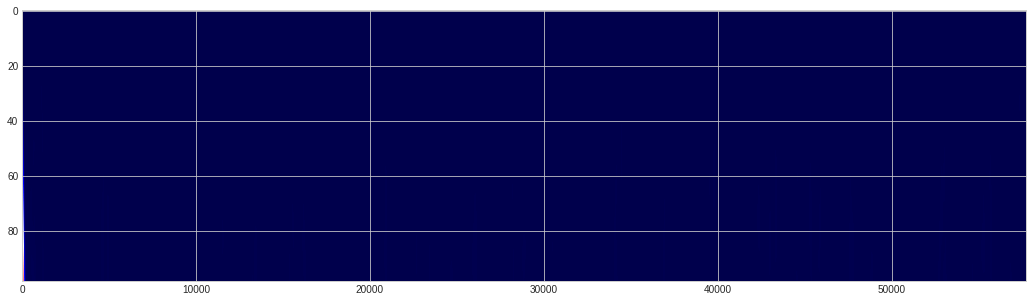

In [ ]:
scales = np.arange(1,100)
plt.figure(figsize=(18,5))
# fig, ax = plt.subplots(figsize=(224,224))
coefficients, frequencies = pywt.cwt(np.float32(eeg_list[0].iloc[:,6]), scales=scales, wavelet="cmor1.5-1.0", sampling_period=256, method="fft", axis=0)
plt.imshow(np.abs(coefficients), cmap="seismic", aspect="auto");
# plt.matshow(coefficients, cmap="seismic", aspect="auto");

In [ ]:
eeg_list[0]

,PO7,PO3,POz,PO4,PO8,O1,Oz,O2,Event
0,-1060.335571,-85.672676,195.264771,353.811188,-518.587891,-298.196686,-304.575867,-697.454468,0
1,-4391.108887,-280.387939,647.012390,1711.082153,-1879.620483,-1563.722046,-1583.941406,-3070.418945,0
2,-6673.524902,-160.418365,389.287079,3495.326660,-1885.986572,-3580.973633,-3586.791748,-5336.872559,0
3,-4101.638184,516.720520,-1195.901123,4289.599121,1123.375977,-5122.143555,-5059.679199,-4925.265625,0
4,-600.986816,1117.116577,-2721.778809,4399.416016,4081.961426,-5982.529297,-5846.979004,-3711.430176,0
...,...,...,...,...,...,...,...,...,...
57723,6.726040,4.468168,3.468754,3.718039,4.409559,7.837559,7.417085,6.878790,0
57724,3.786460,3.100144,1.307947,3.003564,3.264575,5.195788,6.382321,5.719792,0
57725,-0.211839,-0.429037,-2.325564,-0.241900,0.331145,0.366751,2.436171,2.229627,0
57726,-1.114811,-1.455616,-1.932424,-1.524979,-0.535545,-1.652583,1.070238,1.399415,0


In [ ]:
eeg_list[0].iloc[:,6]

0        -304.575867
1       -1583.941406
2       -3586.791748
3       -5059.679199
4       -5846.979004
            ...     
57723       7.417085
57724       6.382321
57725       2.436171
57726       1.070238
57727       1.069368
Name: Oz, Length: 57728, dtype: float64